In [ ]:
!pip install torch torchvision pandas scikit-learn matplotlib tables pyarrow

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchviz import make_dot, make_dot_from_trace

import math
from collections import defaultdict, OrderedDict
import copy

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, mean_absolute_error, matthews_corrcoef

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
store = pd.HDFStore('../ukdale.h5') #需要按照自己文件位置修改

In [3]:
def resample_meter(store=None, building=1, meter=1, period='1min', cutoff=1000.):
    key = '/building{}/elec/meter{}'.format(building,meter)
    m = store[key]
    v = m.values.flatten()
    t = m.index
    s = pd.Series(v, index=t).clip(0.,cutoff)
    s[s<10.] = 0.
    return s.resample('1s').ffill(limit=300).fillna(0.).resample(period).mean().tz_convert('UTC')


In [6]:
def get_series(datastore, house, label, cutoff):
    filename = './house_%1d_labels.dat' %house   #需要按照自己文件位置修改
    print(filename)
    labels = pd.read_csv(filename, delimiter=' ', header=None, index_col=0).to_dict()[1]
    
    for i in labels:
        if labels[i] == label:
            print(i, labels[i])
            s = resample_meter(store, house, i, '1min', cutoff)
            #s = resample_meter(store, house, i, '6s', cutoff)
    
    s.index.name = 'datetime'
    
    return s

In [7]:
house = 1
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
ds_1 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_1.fillna(method='pad', inplace=True)

ds_1_train = ds_1[pd.datetime(2013,4,12):pd.datetime(2014,12,15)]
ds_1_valid = ds_1[pd.datetime(2014,12,15):]

../house_1_labels.dat
1 aggregate
../house_1_labels.dat
10 kettle
../house_1_labels.dat
12 fridge
../house_1_labels.dat
5 washing_machine
../house_1_labels.dat
13 microwave
../house_1_labels.dat
6 dishwasher


C:\usertemp\xundao\ipykernel_19192\3829807372.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_1_train = ds_1[pd.datetime(2013,4,12):pd.datetime(2014,12,15)]
C:\usertemp\xundao\ipykernel_19192\3829807372.py:17: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_1_train = ds_1[pd.datetime(2013,4,12):pd.datetime(2014,12,15)]
C:\usertemp\xundao\ipykernel_19192\3829807372.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_1_valid = ds_1[pd.datetime(2014,12,15):]
C:\usertemp\xundao\ipykernel_19192\3829807372.py:18: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a futu

In [8]:
house = 2
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dish_washer', 2500.)
a5.name = 'dish_washer'
ds_2 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_2.fillna(method='pad', inplace=True)

#ds_2_train = ds_2[pd.datetime(2013,5,22):pd.datetime(2013,10,3,6,16)]
#ds_2_valid = ds_2[pd.datetime(2013,10,3,6,16):]
ds_2_train = ds_2[pd.Timestamp(2013,5,22):pd.Timestamp(2013,10,3,6,16)]
ds_2_valid = ds_2[pd.Timestamp(2013,10,3,6,16):]


../house_2_labels.dat
1 aggregate
../house_2_labels.dat
8 kettle
../house_2_labels.dat
14 fridge
../house_2_labels.dat
12 washing_machine
../house_2_labels.dat
15 microwave
../house_2_labels.dat
13 dish_washer


C:\usertemp\xundao\ipykernel_19192\845194013.py:19: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_2_train = ds_2[pd.Timestamp(2013,5,22):pd.Timestamp(2013,10,3,6,16)]
C:\usertemp\xundao\ipykernel_19192\845194013.py:20: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_2_valid = ds_2[pd.Timestamp(2013,10,3,6,16):]


In [9]:
house = 3
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = 0.*m
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'
ds_3 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_3.fillna(method='pad', inplace=True)

ds_3_train = ds_3[pd.datetime(2013,2,27):pd.datetime(2013,4,1,6,15)]
ds_3_valid = ds_3[pd.datetime(2013,4,1,6,15):]

../house_3_labels.dat
1 aggregate
../house_3_labels.dat
2 kettle


C:\usertemp\xundao\ipykernel_19192\2982668517.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_3_train = ds_3[pd.datetime(2013,2,27):pd.datetime(2013,4,1,6,15)]
C:\usertemp\xundao\ipykernel_19192\2982668517.py:17: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_3_train = ds_3[pd.datetime(2013,2,27):pd.datetime(2013,4,1,6,15)]
C:\usertemp\xundao\ipykernel_19192\2982668517.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_3_valid = ds_3[pd.datetime(2013,4,1,6,15):]
C:\usertemp\xundao\ipykernel_19192\2982668517.py:18: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError 

In [10]:
house = 4
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle_radio', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'freezer', 300.)
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'
ds_4 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_4.fillna(method='pad', inplace=True)

ds_4_train = ds_4[pd.datetime(2013,3,9):pd.datetime(2013,9,24,6,15)]
ds_4_valid = ds_4[pd.datetime(2013,9,24,6,15):]

../house_4_labels.dat
1 aggregate
../house_4_labels.dat
3 kettle_radio
../house_4_labels.dat
5 freezer


C:\usertemp\xundao\ipykernel_19192\1070642271.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_4_train = ds_4[pd.datetime(2013,3,9):pd.datetime(2013,9,24,6,15)]
C:\usertemp\xundao\ipykernel_19192\1070642271.py:17: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_4_train = ds_4[pd.datetime(2013,3,9):pd.datetime(2013,9,24,6,15)]
C:\usertemp\xundao\ipykernel_19192\1070642271.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_4_valid = ds_4[pd.datetime(2013,9,24,6,15):]
C:\usertemp\xundao\ipykernel_19192\1070642271.py:18: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError

In [11]:
house = 5
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge_freezer', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washer_dryer', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
ds_5 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_5.fillna(method='pad', inplace=True)

ds_5_train = ds_5[pd.datetime(2014,6,29):pd.datetime(2014,9,1)]
ds_5_valid = ds_5[pd.datetime(2014,9,1):]

../house_5_labels.dat
1 aggregate
../house_5_labels.dat
18 kettle
../house_5_labels.dat
19 fridge_freezer
../house_5_labels.dat
24 washer_dryer
../house_5_labels.dat
23 microwave
../house_5_labels.dat
22 dishwasher


C:\usertemp\xundao\ipykernel_19192\2498256263.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_5_train = ds_5[pd.datetime(2014,6,29):pd.datetime(2014,9,1)]
C:\usertemp\xundao\ipykernel_19192\2498256263.py:17: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_5_train = ds_5[pd.datetime(2014,6,29):pd.datetime(2014,9,1)]
C:\usertemp\xundao\ipykernel_19192\2498256263.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_5_valid = ds_5[pd.datetime(2014,9,1):]
C:\usertemp\xundao\ipykernel_19192\2498256263.py:18: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future ver

In [12]:
ds_1_train.reset_index().to_feather('./UKDALE_1_train.feather')
ds_2_train.reset_index().to_feather('./UKDALE_2_train.feather')
ds_3_train.reset_index().to_feather('./UKDALE_3_train.feather')
ds_4_train.reset_index().to_feather('./UKDALE_4_train.feather')
ds_5_train.reset_index().to_feather('./UKDALE_5_train.feather')

ds_1_valid.reset_index().to_feather('./UKDALE_1_valid.feather')
ds_2_valid.reset_index().to_feather('./UKDALE_2_valid.feather')
ds_3_valid.reset_index().to_feather('./UKDALE_3_valid.feather')
ds_4_valid.reset_index().to_feather('./UKDALE_4_valid.feather')
ds_5_valid.reset_index().to_feather('./UKDALE_5_valid.feather')

# Read the feather dataframe resampled

In [13]:
def get_status(app, threshold, min_off, min_on):
    condition = app > threshold
    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    on_events = idx[:,0].copy()
    off_events = idx[:,1].copy()
    assert len(on_events) == len(off_events)

    if len(on_events) > 0:
        off_duration = on_events[1:] - off_events[:-1]
        off_duration = np.insert(off_duration, 0, 1000.)
        on_events = on_events[off_duration > min_off]
        off_events = off_events[np.roll(off_duration, -1) > min_off]
        assert len(on_events) == len(off_events)

        on_duration = off_events - on_events
        on_events = on_events[on_duration > min_on]
        off_events = off_events[on_duration > min_on]

    s = app.copy()
    #s.iloc[:] = 0.
    s[:] = 0.

    for on, off in zip(on_events, off_events):
        #s.iloc[on:off] = 1.
        s[on:off] = 1.
    
    return s

这段代码定义了一个名为get_status的函数，用于从一个电器的用电量数据中获取该电器的状态。该函数接受四个参数：app表示电器的用电量数据，threshold表示电器的开启阈值，min_off表示电器关闭持续时间的最小值，min_on表示电器开启持续时间的最小值。

该函数首先根据阈值将电器的用电量数据转换为布尔型数组condition。然后，它使用numpy库中的diff函数获取condition中相邻元素的差值，并使用nonzero方法获取差值不为0的元素的索引。接着，它将索引向右移动一位，并在开头和结尾处分别添加0和数组长度。最后，它将索引按每两个元素为一组进行划分，并计算出每个组对应的电器开启和关闭时间点，并将其存储在on_events和off_events数组中。

接下来，该函数使用on_events和off_events数组计算出电器关闭持续时间和开启持续时间，并筛选出持续时间大于最小值的时间段。然后，它将每个时间段内的用电量数据标记为1，其余部分标记为0，并将标记后的用电量数据存储在s数组中。

最后，该函数返回标记后的用电量数据s。

In [14]:
class Power(data.Dataset):
    def __init__(self, meter=None, appliance=None, status=None, 
                 length=256, border=680, max_power=1., train=False):
        self.length = length
        self.border = border
        self.max_power = max_power
        self.train = train

        self.meter = meter.copy()/self.max_power
        self.appliance = appliance.copy()/self.max_power
        self.status = status.copy()

        self.epochs = (len(self.meter) - 2*self.border) // self.length
        
    def __getitem__(self, index):
        i = index * self.length + self.border
        if self.train:
            i = np.random.randint(self.border, len(self.meter) - self.length - self.border)

        x = self.meter.iloc[i-self.border:i+self.length+self.border].values.astype('float32')
        y = self.appliance.iloc[i:i+self.length].values.astype('float32')
        s = self.status.iloc[i:i+self.length].values.astype('float32')
        x -= x.mean()
        
        return x, y, s

    def __len__(self):
        return self.epochs

这段代码定义了一个名为`Power`的数据集类，用于从电器的用电量数据中生成训练和测试数据。该类的初始化函数接受五个参数：`meter`表示电表的用电量数据，`appliance`表示电器的用电量数据，`status`表示电器的状态数据，`length`表示每个样本的长度，`border`表示每个样本的边界长度，`max_power`表示用电量数据的最大值，`train`表示是否为训练数据。

该类实现了两个方法：`__getitem__`和`__len__`。其中，`__getitem__`方法用于获取指定索引的样本数据，它首先计算出样本的起始位置`i`，如果是训练数据，则随机生成一个起始位置。然后，它从电表和电器的用电量数据中获取指定位置和长度的数据，并将其存储在`x`和`y`数组中。同时，它还从电器的状态数据中获取指定位置和长度的状态数据，并将其存储在`s`数组中。最后，它将`x`数组减去平均值，并返回三个数组作为样本数据。

x：表示电表数据（meter data）。它是一个时间序列，包含了电表的读数。在代码中，x被定义为一个Numpy数组，包含了从(i-self.border)到(i+self.length+self.border)的电表数据。
y：表示电器数据（appliance data）。它也是一个时间序列，包含了特定电器的能耗数据。在代码中，y被定义为一个Numpy数组，包含了从i到(i+self.length)的电器数据。
s：表示状态数据（status data）。它也是一个时间序列，包含了与电器状态相关的数据。在代码中，s被定义为一个Numpy数组，包含了从i到(i+self.length)的状态数据。

`__len__`方法用于返回整个数据集中样本的数量，它计算出整个数据集中可以生成的样本数，并返回该数值。

In [15]:
#引入MUSEAttention模块
class Depth_Pointwise_Conv1d(nn.Module):
    def __init__(self, in_ch, out_ch, k):
        super().__init__()
        if (k == 1):
            self.depth_conv = nn.Identity()
        else:
            self.depth_conv = nn.Conv1d(
                in_channels=in_ch,
                out_channels=in_ch,
                kernel_size=k,
                groups=in_ch,
                padding=k // 2
            )
        self.pointwise_conv = nn.Conv1d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=1,
            groups=1
        )

    def forward(self, x):
        out = self.pointwise_conv(self.depth_conv(x))
        return out


class MUSEAttention(nn.Module):

    def __init__(self, d_model, d_k, d_v, h, dropout=.1):

        super(MUSEAttention, self).__init__()
        self.fc_q = nn.Linear(d_model, h * d_k)
        self.fc_k = nn.Linear(d_model, h * d_k)
        self.fc_v = nn.Linear(d_model, h * d_v)
        self.fc_o = nn.Linear(h * d_v, d_model)
        self.dropout = nn.Dropout(dropout)

        self.conv1 = Depth_Pointwise_Conv1d(h * d_v, d_model, 1)
        self.conv3 = Depth_Pointwise_Conv1d(h * d_v, d_model, 3)
        self.conv5 = Depth_Pointwise_Conv1d(h * d_v, d_model, 5)
        self.dy_paras = nn.Parameter(torch.ones(3))
        self.softmax = nn.Softmax(-1)

        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.h = h

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, queries, keys, values, attention_mask=None, attention_weights=None):

        # Self Attention
        b_s, nq = queries.shape[:2]
        nk = keys.shape[1]

        q = self.fc_q(queries).view(b_s, nq, self.h, self.d_k).permute(0, 2, 1, 3)  # (b_s, h, nq, d_k)
        k = self.fc_k(keys).view(b_s, nk, self.h, self.d_k).permute(0, 2, 3, 1)  # (b_s, h, d_k, nk)
        v = self.fc_v(values).view(b_s, nk, self.h, self.d_v).permute(0, 2, 1, 3)  # (b_s, h, nk, d_v)

        att = torch.matmul(q, k) / np.sqrt(self.d_k)  # (b_s, h, nq, nk)
        if attention_weights is not None:
            att = att * attention_weights
        if attention_mask is not None:
            att = att.masked_fill(attention_mask, -np.inf)
        att = torch.softmax(att, -1)
        att = self.dropout(att)

        out = torch.matmul(att, v).permute(0, 2, 1, 3).contiguous().view(b_s, nq, self.h * self.d_v)  # (b_s, nq, h*d_v)
        out = self.fc_o(out)  # (b_s, nq, d_model)

        v2 = v.permute(0, 1, 3, 2).contiguous().view(b_s, -1, nk)  # bs,dim,n
        self.dy_paras = nn.Parameter(self.softmax(self.dy_paras))
        out2 = self.dy_paras[0] * self.conv1(v2) + self.dy_paras[1] * self.conv3(v2) + self.dy_paras[2] * self.conv5(v2)
        out2 = out2.permute(0, 2, 1)  # bs.n.dim

        out = out + out2
        return out


### MUSENILM模型

In [16]:
class Encoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=3, padding=1, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=kernel_size, padding=padding, stride=stride,
                              bias=False)
        # self.conv=LSKblock(out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        # return self.bn(F.relu(self.conv(x)))
        return self.drop(self.bn(F.relu(self.conv(x))))


class TemporalPooling(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2):
        super(TemporalPooling, self).__init__()
        self.kernel_size = kernel_size
        self.pool = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.kernel_size)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, padding=0)
        # self.upsample = nn.Upsample( scale_factor=kernel_size, mode='linear', align_corners=True)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(F.relu(x))
        # return self.upsample(x)
        # return self.drop(self.upsample(x))
        return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='linear', align_corners=True))
        #return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='nearest', align_corners=True))
        #return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='bicubic', align_corners=True))


class Decoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2, stride=2):
        super(Decoder, self).__init__()
        self.conv = nn.ConvTranspose1d(in_features, out_features, kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        return F.relu(self.conv(x))


class PTPNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(PTPNet, self).__init__()
        p = 2
        k = 1
        features = init_features
        self.encoder1 = Encoder(in_channels, features, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool1_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder2 = Encoder(features * 1 ** k, features * 2 ** k, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool2_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder3 = Encoder(features * 2 ** k, features * 4 ** k, kernel_size=3, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool3_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder4 = Encoder(features * 4 ** k, features * 10 ** k, kernel_size=3, padding=0)
        self.MUSEA = MUSEAttention(d_model=30, d_k=30, d_v=30, h=8)
        
        self.tpool1 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=5)
        self.tpool2 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=10)
        self.tpool3 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=15)
        self.tpool4 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=30)
        self.tpool5 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=25)
        self.tpool6 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=15)
        self.tpool7 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=5)

        self.decoder = Decoder(2 * features * 12 ** k, features * 1 ** k, kernel_size=p ** 3, stride=p ** 3)

        self.activation = nn.Conv1d(features * 1 ** k, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
       # print('x:',x.shape)
        enc1 = self.encoder1(x)
        #print('enc1:',enc1.shape)
        enc2 = self.encoder2(self.pool1(enc1)+self.pool1_1(enc1))
       # print('enc2:',enc2.shape)
        enc3 = self.encoder3(self.pool2(enc2)+self.pool2_1(enc2))
       # print('enc3:',enc3.shape)
        enc4 = self.encoder4(self.pool3(enc3)+self.pool3_1(enc3))
        #print('enc4:',enc4.shape)
        mu1 = self.MUSEA(enc4, enc4, enc4)
        
        tp1 = self.tpool1(mu1)
       # print('tp1:',tp1.shape)
        tp2 = self.tpool2(mu1)
        #print('tp2:',tp2.shape)
        tp3 = self.tpool3(mu1)
       # print('tp3:',tp3.shape)
        tp4 = self.tpool4(mu1)
        #print('tp4:',tp4.shape)
        tp5 = self.tpool6(mu1)
        #print('tp5:',tp5.shape)
        tp6 = self.tpool6(mu1)
        #print('tp6:',tp6.shape)
        tp7 = self.tpool7(mu1)
        #print('tp7:',tp7.shape)
        
        dec = self.decoder(torch.cat([mu1, tp1, tp2, tp3, tp4, tp5, tp6, tp7], dim=1))
        #print('dec:',dec.shape)

        act = self.activation(dec)
        #print('act:',act.shape)
        return act


x = torch.randn(32, 1, 270)
x = x.to('cuda')
model = PTPNet(1,3,32).cuda()
#print(model)
#print(model(x).shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

549902


### UNMUSENILM模型

In [19]:
class Encoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=3, padding=1, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=kernel_size, padding=padding, stride=stride,
                              bias=False)
        # self.conv=LSKblock(out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        # return self.bn(F.relu(self.conv(x)))
        return self.drop(self.bn(F.relu(self.conv(x))))


class TemporalPooling(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2):
        super(TemporalPooling, self).__init__()
        self.kernel_size = kernel_size
        self.pool = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.kernel_size)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, padding=0)
        # self.upsample = nn.Upsample( scale_factor=kernel_size, mode='linear', align_corners=True)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(F.relu(x))
        # return self.upsample(x)
        # return self.drop(self.upsample(x))
        return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='linear', align_corners=True))
        #return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='nearest', align_corners=True))
        #return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='bicubic', align_corners=True))


class Decoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2, stride=2):
        super(Decoder, self).__init__()
        self.conv = nn.ConvTranspose1d(in_features, out_features, kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        return F.relu(self.conv(x))


class PTPNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(PTPNet, self).__init__()
        p = 2
        k = 1
        features = init_features
        self.encoder1 = Encoder(in_channels, features, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool1_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder2 = Encoder(features * 1 ** k, features * 2 ** k, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool2_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder3 = Encoder(features * 2 ** k, features * 4 ** k, kernel_size=3, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool3_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder4 = Encoder(features * 4 ** k, features * 10 ** k, kernel_size=3, padding=0)
        #self.MUSEA = MUSEAttention(d_model=30, d_k=30, d_v=30, h=8)
        
        self.tpool1 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=5)
        self.tpool2 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=10)
        self.tpool3 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=15)
        self.tpool4 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=30)
        self.tpool5 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=25)
        self.tpool6 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=15)
        self.tpool7 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=5)

        self.decoder = Decoder(2 * features * 12 ** k, features * 1 ** k, kernel_size=p ** 3, stride=p ** 3)

        self.activation = nn.Conv1d(features * 1 ** k, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
       # print('x:',x.shape)
        enc1 = self.encoder1(x)
        #print('enc1:',enc1.shape)
        enc2 = self.encoder2(self.pool1(enc1)+self.pool1_1(enc1))
       # print('enc2:',enc2.shape)
        enc3 = self.encoder3(self.pool2(enc2)+self.pool2_1(enc2))
       # print('enc3:',enc3.shape)
        enc4 = self.encoder4(self.pool3(enc3)+self.pool3_1(enc3))
       # print('enc4:',enc4.shape)
        #mu1 = self.MUSEA(enc4, enc4, enc4)
        
        tp1 = self.tpool1(enc4)
       # print('tp1:',tp1.shape)
        tp2 = self.tpool2(enc4)
        #print('tp2:',tp2.shape)
        tp3 = self.tpool3(enc4)
       # print('tp3:',tp3.shape)
        tp4 = self.tpool4(enc4)
        #print('tp4:',tp4.shape)
        tp5 = self.tpool6(enc4)
        #print('tp5:',tp5.shape)
        tp6 = self.tpool6(enc4)
        #print('tp6:',tp6.shape)
        tp7 = self.tpool7(enc4)
        #print('tp7:',tp7.shape)
        
        dec = self.decoder(torch.cat([enc4, tp1, tp2, tp3, tp4, tp5, tp6, tp7], dim=1))
        #print('dec:',dec.shape)

        act = self.activation(dec)
        #print('act:',act.shape)
        return act


x = torch.randn(32, 1, 270)
x = x.to('cuda')
model = PTPNet(1,3,32).cuda()
#print(model)
#print(model(x).shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

496259


In [7]:
import os
#os.environ["PATH"] += os.pathsep + 'F:/ruanjian/Graphviz/bin/'

dot = make_dot(model(x), params=dict(model.named_parameters()))

# 保存为图片到当前文件夹
dot.render('model_visualization_1121', format='png')

'model_visualization_1121.png'

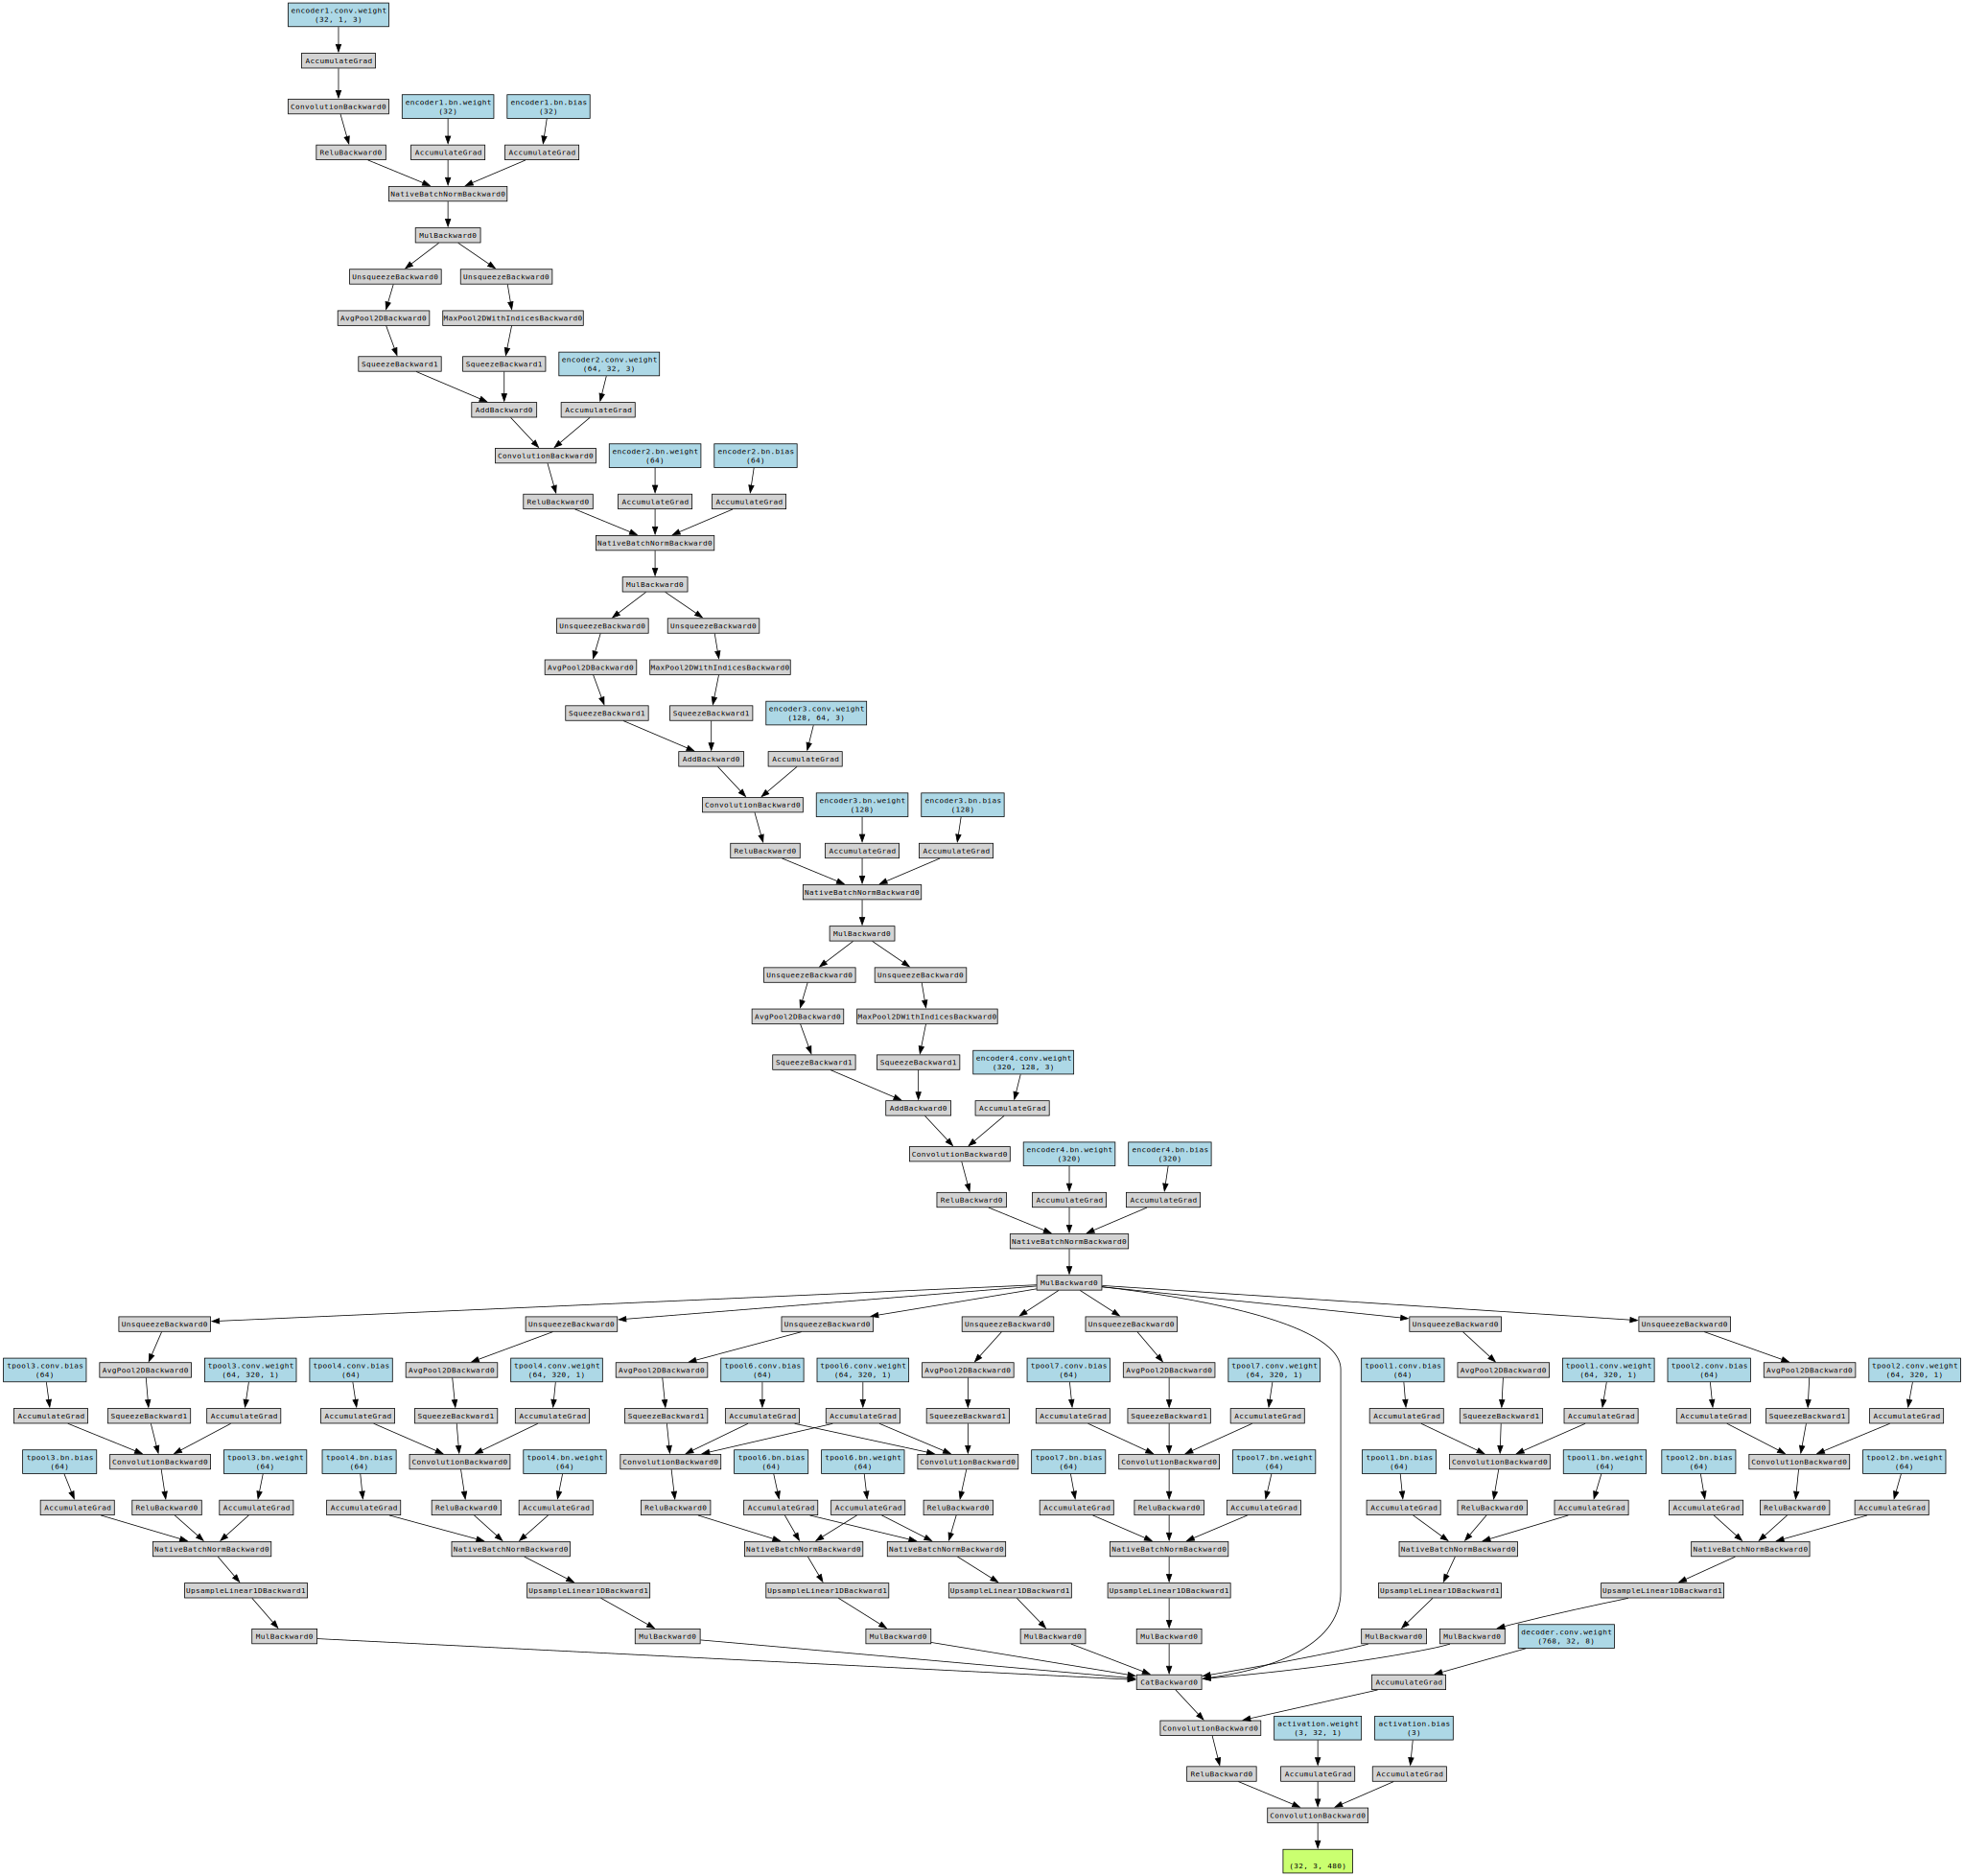

In [9]:
dot

In [17]:
def train_model(model, batch_size, n_epochs, filename):
    
    # 用于跟踪训练过程中的训练损失
    train_losses = []
    # 用于跟踪训练过程中的验证损失
    valid_losses = []
    # 用于跟踪训练过程中的测试损失
    test_losses = []
    # 用于跟踪每个 epoch 的平均训练损失
    avg_train_losses = []
    # 用于跟踪每个 epoch 的平均验证损失
    avg_valid_losses = [] 
    # 用于跟踪每个 epoch 的平均测试损失
    avg_test_losses = [] 
    
    min_loss = np.inf
    
    # 初始化 early_stopping 对象
    #patience = 10
    #early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # 训练模型 #
        ###################
        model.train() # 准备模型进行训练
        for batch, (data, target_power, target_status) in enumerate(train_loader, 1):
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # 清除所有优化变量的梯度
            optimizer.zero_grad()
            # 前向传播：通过将输入传递给模型来计算预测输出
            output_status = model(data).permute(0,2,1)
            # 计算损失
            loss = criterion(output_status, target_status)
            # 反向传播：计算损失相对于模型参数的梯度
            loss.backward()
            # 执行单次优化步骤（参数更新）
            optimizer.step()
            # 记录训练损失
            train_losses.append(loss.item())

        ######################    
        # 验证模型 #
        ######################
        model.eval() # 准备模型进行评估
        for data, target_power, target_status in valid_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # 前向传播：通过将输入传递给模型来计算预测输出
            output_status = model(data).permute(0,2,1)
            # 计算损失
            loss = criterion(output_status, target_status)
            # 记录验证损失
            valid_losses.append(loss.item())

        ##################    
        # 测试模型 #
        ##################
        model.eval() # 准备模型进行评估
        for data, target_power, target_status in test_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # 前向传播：通过将输入传递给模型来计算预测输出
            output_status = model(data).permute(0,2,1)
            # 计算损失
            loss = criterion(output_status, target_status)
            # 记录测试损失
            test_losses.append(loss.item())

        # 打印训练/验证统计信息
        # 计算一个 epoch 的平均损失
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        test_loss = np.average(test_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_test_losses.append(test_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'test_loss: {test_loss:.5f} ')
        
        print(print_msg)
        
        # 清空列表以跟踪下一个 epoch
        train_losses = []
        valid_losses = []
        test_losses = []
        
        # early_stopping 需要验证损失来检查是否有减少，
        # 如果有减少，它将创建当前模型的检查点
        #early_stopping(valid_loss, model)
        #if (early_stopping.early_stop and (epoch > 80)):
        #    break
        
        if valid_loss < min_loss:
            print(f'验证损失减少 ({min_loss:.6f} --> {valid_loss:.6f}). 正在保存模型...')
            torch.save(model.state_dict(), filename)
            min_loss = valid_loss
        
    # 加载具有最佳模型的最后一个检查点
    model.load_state_dict(torch.load(filename))
    
    return  model, avg_train_losses, avg_valid_losses, avg_test_losses


这段代码定义了一个训练模型的函数train_model，用于训练神经网络模型。在训练过程中，该函数会迭代多个epoch，每个epoch会对训练集、验证集和测试集进行一次前向传播和反向传播，并计算损失值。在每个epoch结束时，该函数会输出该epoch的平均训练损失、平均验证损失和平均测试损失，并将最好的模型保存下来。该函数的返回值包括训练好的模型和每个epoch的平均损失值。

In [18]:
def evaluate_activation(model, loader, a):
    x_true = []
    s_true = []
    p_true = []
    s_hat = []
    
    model.eval()
    with torch.no_grad():
        for x, p, s in loader:
            x = x.unsqueeze(1).cuda()
            p = p.permute(0,2,1)[:,a,:]
            s = s.permute(0,2,1)[:,a,:]
            
            sh = model(x)
            sh = torch.sigmoid(sh[:,a,:])
            
            s_hat.append(sh.contiguous().view(-1).detach().cpu().numpy())
            
            x_true.append(x[:,:,BORDER:-BORDER].contiguous().view(-1).detach().cpu().numpy())
            s_true.append(s.contiguous().view(-1).detach().cpu().numpy())
            p_true.append(p.contiguous().view(-1).detach().cpu().numpy())
    x_true = np.hstack(x_true)
    s_true = np.hstack(s_true)
    p_true = np.hstack(p_true)
    s_hat = np.hstack(s_hat)

    return x_true, p_true, s_true, s_hat

这段代码是一个函数，用于评估模型在给定数据集上的激活结果。

首先，在函数内部定义了四个空列表：x_true、s_true、p_true和s_hat，用于存储计算结果。

接下来，将模型设置为评估模式，即model.eval()。

然后，通过一个循环遍历数据加载器loader中的每个批次。在每个批次中，执行以下操作：

将输入数据x从(batch_size, sequence_length)的形状转换为(batch_size, 1, sequence_length)的形状，并将其移到GPU上（假设有可用的CUDA设备）。
使用permute函数对位置编码p和状态s进行维度转换，将其从(batch_size, num_features, sequence_length)的形状转换为(batch_size, sequence_length)的形状，并选择第a个特征。
将处理后的输入数据x输入到模型中，得到输出sh。使用sigmoid函数对输出进行激活，只选择第a个特征。
将激活结果sh展平并转换为NumPy数组，然后将其添加到s_hat列表中。
对输入数据x、位置编码p和状态s进行类似的处理，将它们展平并转换为NumPy数组，然后分别添加到x_true、s_true和p_true列表中。
在循环结束后，将x_true、s_true、p_true和s_hat列表中的所有元素堆叠起来，得到最终的结果x_true、p_true、s_true和s_hat。

最后，将这四个结果作为函数的返回值。

In [19]:
APPLIANCE = ['fridge', 'dish_washer', 'washing_machine']
THRESHOLD = [50., 10., 20.]
MIN_ON = [1., 30., 30.]
MIN_OFF = [1., 30., 3.]

METER = 'aggregate'
SEQ_LEN = 60*4   #输出时间序列长度1440
BORDER = 16   #边界宽度
#输入为SEQ_LEN+BORDER*2-2=1470
BATCH_SIZE = 32

MAX_POWER = 2000.

In [20]:
ds_meter = []
ds_appliance = []
ds_status = []
for i in range(5):
    ds = pd.read_feather('./UKDALE_%d_train.feather' %(i+1))
    ds.set_index('datetime', inplace=True)
    print(ds)
    
    meter = ds[METER]
    appliances = ds[APPLIANCE]
    
    status = pd.DataFrame()
    for a in range(len(APPLIANCE)):
        status = pd.concat([status, get_status(ds[APPLIANCE[a]], THRESHOLD[a], MIN_OFF[a], MIN_ON[a])], axis=1)
    
    ds_meter.append(meter)
    ds_appliance.append(appliances)
    ds_status.append(status)

ds_len = [len(ds_meter[i]) for i in range(5)]

                            aggregate  kettle     fridge  washing_machine  \
datetime                                                                    
2013-04-12 00:00:00+00:00  166.416672     0.0   0.000000              0.0   
2013-04-12 00:01:00+00:00  166.816666     0.0   0.000000              0.0   
2013-04-12 00:02:00+00:00  168.083328     0.0   0.000000              0.0   
2013-04-12 00:03:00+00:00  167.199997     0.0   0.000000              0.0   
2013-04-12 00:04:00+00:00  167.383331     0.0   0.000000              0.0   
...                               ...     ...        ...              ...   
2014-12-14 23:56:00+00:00  210.449997     0.0  78.066666              0.0   
2014-12-14 23:57:00+00:00  208.533340     0.0  79.699997              0.0   
2014-12-14 23:58:00+00:00  209.333328     0.0  76.900002              0.0   
2014-12-14 23:59:00+00:00  186.516663     0.0  50.049999              0.0   
2014-12-15 00:00:00+00:00  165.399994     0.0   0.000000              0.0   

这段代码首先定义了一些常量，包括家电的名称、阈值、最小开启时间和最小关闭时间，以及一些数据处理相关的参数。然后，通过循环读取5个训练数据集，并将其存储在ds_meter、ds_appliance和ds_status列表中。其中，ds_meter存储了总用电量数据，ds_appliance存储了各个家电的用电量数据，ds_status存储了家电的状态数据。

In [21]:
ds_meter[0]

datetime
2013-04-12 00:00:00+00:00    166.416672
2013-04-12 00:01:00+00:00    166.816666
2013-04-12 00:02:00+00:00    168.083328
2013-04-12 00:03:00+00:00    167.199997
2013-04-12 00:04:00+00:00    167.383331
                                ...    
2014-12-14 23:56:00+00:00    210.449997
2014-12-14 23:57:00+00:00    208.533340
2014-12-14 23:58:00+00:00    209.333328
2014-12-14 23:59:00+00:00    186.516663
2014-12-15 00:00:00+00:00    165.399994
Name: aggregate, Length: 881281, dtype: float32

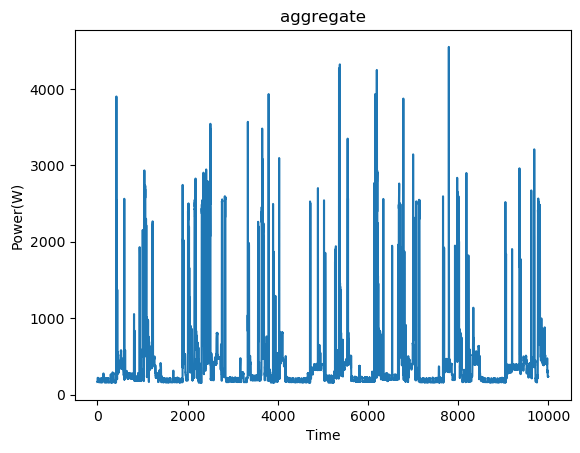

In [22]:
data = [
    (i, value) for i, value in enumerate(ds_meter[0][:10000])
]

# 提取序列号和值
indices = [d[0] for d in data]
values = [d[1] for d in data]

# 创建折线图
plt.plot(indices, values)

# 添加标题和标签
plt.title('aggregate')
plt.xlabel('Time')
plt.ylabel('Power(W)')

# 显示图形
plt.show()

# 设置分辨率为600ppi
dpi = 600

# 设置图表尺寸，以英寸为单位
#fig = plt.figure(figsize=(8, 6))  # 这里将宽度设置为8英寸，高度设置为6英寸，你可以根据需要进行调整

# 选择文件路径和文件名，保存为PNG格式
save_path = r'D:\NILM\绘图\image.png'

# 导出图片
#plt.savefig(save_path, dpi=dpi)


接下来，代码统计了ds_status[1]中状态变化为1的次数，并对ds_status[1]进行了描述性统计。

In [23]:
ds_house_train = [Power(ds_meter[i][:int(0.8*ds_len[i])], 
                        ds_appliance[i][:int(0.8*ds_len[i])], 
                        ds_status[i][:int(0.8*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, True) for i in range(5+0)]

ds_house_valid = [Power(ds_meter[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        ds_appliance[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])],
                        ds_status[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_test  = [Power(ds_meter[i][int(0.9*ds_len[i]):], 
                        ds_appliance[i][int(0.9*ds_len[i]):],
                        ds_status[i][int(0.9*ds_len[i]):], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_total  = [Power(ds_meter[i], ds_appliance[i], ds_status[i], 
                         SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_train_seen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                ds_house_train[1], 
                                                #ds_house_train[2], 
                                                #ds_house_train[3],
                                                ds_house_train[4]
                                                ])
ds_valid_seen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                #ds_house_valid[1], 
                                                #ds_house_valid[2], 
                                                #ds_house_valid[3], 
                                                #ds_house_valid[4]
                                                ])

dl_train_seen = DataLoader(dataset = ds_train_seen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_seen = DataLoader(dataset = ds_valid_seen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_seen = DataLoader(dataset = ds_house_test[0], batch_size = BATCH_SIZE, shuffle=False)

ds_train_unseen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                  #ds_house_train[1], 
                                                  #ds_house_train[2], 
                                                  #ds_house_train[3], 
                                                  ds_house_train[4]
                                                  ])
ds_valid_unseen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                  #ds_house_valid[1], 
                                                  #ds_house_valid[2], 
                                                  #ds_house_valid[3], 
                                                  ds_house_valid[4]
                                                  ])
dl_train_unseen = DataLoader(dataset = ds_train_unseen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_unseen = DataLoader(dataset = ds_valid_unseen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_unseen = DataLoader(dataset = ds_house_total[1], batch_size = BATCH_SIZE, shuffle=False)

dl_house_test = [DataLoader(dataset = ds_house_test[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_valid = [DataLoader(dataset = ds_house_valid[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_total = [DataLoader(dataset = ds_house_total[i], batch_size = 1, shuffle=False) for i in range(5)]

这段代码定义了多个数据集和数据加载器，用于训练和测试神经网络模型。首先，代码根据数据集的长度将数据集分为训练集、验证集和测试集，并将每个家庭的数据存储在不同的数据集中。然后，代码使用`ConcatDataset`将不同家庭的数据集合并成一个数据集，并将其传递给`DataLoader`进行批量加载。其中，`dl_train_seen`和`dl_valid_seen`是已知家电的训练集和验证集数据加载器，`dl_test_seen`是已知家电的测试集数据加载器，`dl_train_unseen`和`dl_valid_unseen`是未知家电的训练集和验证集数据加载器，`dl_test_unseen`是未知家电的测试集数据加载器。

最后，代码定义了多个用于单独加载每个家庭数据的数据加载器`dl_house_test`、`dl_house_valid`和`dl_house_total`。

In [27]:
batch_size = BATCH_SIZE
n_epochs = 500

train_loader = dl_train_seen
valid_loader = dl_valid_seen
test_loader = dl_test_seen

#i = 0
for i in range(20):
#for i in range(1):
    print('TRAINING MODEL %d' %i)
    # Instantiate the model
    #model = LSTMModel(input_size, hidden_size, output_size).cuda()
    model = PTPNet(1,3,32).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1.E-4)
    criterion = nn.BCEWithLogitsLoss()
    fn = 'UKDALE_seen_13_1110%d.pth' %i
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, fn)

TRAINING MODEL 0
[  1/500] train_loss: 0.39283 valid_loss: 0.27883 test_loss: 0.28490 
验证损失减少 (inf --> 0.278825). 正在保存模型...
[  2/500] train_loss: 0.22540 valid_loss: 0.20778 test_loss: 0.21709 
验证损失减少 (0.278825 --> 0.207784). 正在保存模型...
[  3/500] train_loss: 0.17745 valid_loss: 0.17634 test_loss: 0.18568 
验证损失减少 (0.207784 --> 0.176336). 正在保存模型...
[  4/500] train_loss: 0.16008 valid_loss: 0.16067 test_loss: 0.17210 
验证损失减少 (0.176336 --> 0.160670). 正在保存模型...
[  5/500] train_loss: 0.14533 valid_loss: 0.14967 test_loss: 0.16252 
验证损失减少 (0.160670 --> 0.149669). 正在保存模型...
[  6/500] train_loss: 0.14200 valid_loss: 0.14455 test_loss: 0.15767 
验证损失减少 (0.149669 --> 0.144555). 正在保存模型...
[  7/500] train_loss: 0.13873 valid_loss: 0.13860 test_loss: 0.15205 
验证损失减少 (0.144555 --> 0.138603). 正在保存模型...
[  8/500] train_loss: 0.13396 valid_loss: 0.13433 test_loss: 0.14964 
验证损失减少 (0.138603 --> 0.134326). 正在保存模型...
[  9/500] train_loss: 0.12893 valid_loss: 0.13106 test_loss: 0.14788 
验证损失减少 (0.134326 --> 0

[ 94/500] train_loss: 0.08186 valid_loss: 0.08691 test_loss: 0.10015 
验证损失减少 (0.088367 --> 0.086911). 正在保存模型...
[ 95/500] train_loss: 0.07998 valid_loss: 0.08809 test_loss: 0.10172 
[ 96/500] train_loss: 0.08211 valid_loss: 0.08970 test_loss: 0.10115 
[ 97/500] train_loss: 0.07844 valid_loss: 0.08744 test_loss: 0.10061 
[ 98/500] train_loss: 0.07912 valid_loss: 0.08999 test_loss: 0.10102 
[ 99/500] train_loss: 0.07939 valid_loss: 0.08608 test_loss: 0.09984 
验证损失减少 (0.086911 --> 0.086080). 正在保存模型...
[100/500] train_loss: 0.07880 valid_loss: 0.08831 test_loss: 0.10063 
[101/500] train_loss: 0.08009 valid_loss: 0.08721 test_loss: 0.10117 
[102/500] train_loss: 0.07781 valid_loss: 0.08887 test_loss: 0.09942 
[103/500] train_loss: 0.07739 valid_loss: 0.08556 test_loss: 0.09941 
验证损失减少 (0.086080 --> 0.085562). 正在保存模型...
[104/500] train_loss: 0.07867 valid_loss: 0.08569 test_loss: 0.09880 
[105/500] train_loss: 0.07781 valid_loss: 0.08904 test_loss: 0.09822 
[106/500] train_loss: 0.07840 vali

[201/500] train_loss: 0.06606 valid_loss: 0.07804 test_loss: 0.09078 
[202/500] train_loss: 0.06546 valid_loss: 0.07949 test_loss: 0.09321 
[203/500] train_loss: 0.06623 valid_loss: 0.07998 test_loss: 0.09139 
[204/500] train_loss: 0.06536 valid_loss: 0.07855 test_loss: 0.09034 
[205/500] train_loss: 0.06459 valid_loss: 0.08053 test_loss: 0.09213 
[206/500] train_loss: 0.06616 valid_loss: 0.07897 test_loss: 0.09073 
[207/500] train_loss: 0.06476 valid_loss: 0.08251 test_loss: 0.09022 
[208/500] train_loss: 0.06771 valid_loss: 0.07931 test_loss: 0.09215 
[209/500] train_loss: 0.06721 valid_loss: 0.07826 test_loss: 0.09128 
[210/500] train_loss: 0.06517 valid_loss: 0.07951 test_loss: 0.09089 
[211/500] train_loss: 0.06650 valid_loss: 0.08517 test_loss: 0.09376 
[212/500] train_loss: 0.06679 valid_loss: 0.07981 test_loss: 0.09169 
[213/500] train_loss: 0.06618 valid_loss: 0.07973 test_loss: 0.09270 
[214/500] train_loss: 0.06671 valid_loss: 0.07880 test_loss: 0.09103 
[215/500] train_loss

[314/500] train_loss: 0.05843 valid_loss: 0.07949 test_loss: 0.09132 
[315/500] train_loss: 0.05787 valid_loss: 0.07713 test_loss: 0.08929 
[316/500] train_loss: 0.05967 valid_loss: 0.07660 test_loss: 0.08961 
[317/500] train_loss: 0.05928 valid_loss: 0.07929 test_loss: 0.08943 
[318/500] train_loss: 0.05877 valid_loss: 0.07670 test_loss: 0.08963 
[319/500] train_loss: 0.05985 valid_loss: 0.07575 test_loss: 0.08787 
验证损失减少 (0.076165 --> 0.075754). 正在保存模型...
[320/500] train_loss: 0.06065 valid_loss: 0.08078 test_loss: 0.08816 
[321/500] train_loss: 0.06037 valid_loss: 0.08014 test_loss: 0.08890 
[322/500] train_loss: 0.05926 valid_loss: 0.07741 test_loss: 0.08881 
[323/500] train_loss: 0.05853 valid_loss: 0.07859 test_loss: 0.08997 
[324/500] train_loss: 0.05878 valid_loss: 0.08058 test_loss: 0.08993 
[325/500] train_loss: 0.05656 valid_loss: 0.08046 test_loss: 0.08894 
[326/500] train_loss: 0.05825 valid_loss: 0.07864 test_loss: 0.08922 
[327/500] train_loss: 0.05873 valid_loss: 0.0763

[429/500] train_loss: 0.05341 valid_loss: 0.08183 test_loss: 0.08780 
[430/500] train_loss: 0.05467 valid_loss: 0.07623 test_loss: 0.08851 
[431/500] train_loss: 0.05419 valid_loss: 0.07852 test_loss: 0.08735 
[432/500] train_loss: 0.05350 valid_loss: 0.07657 test_loss: 0.08787 
[433/500] train_loss: 0.05472 valid_loss: 0.07717 test_loss: 0.08806 
[434/500] train_loss: 0.05371 valid_loss: 0.07574 test_loss: 0.08782 
[435/500] train_loss: 0.05370 valid_loss: 0.07672 test_loss: 0.08692 
[436/500] train_loss: 0.05470 valid_loss: 0.08176 test_loss: 0.08768 
[437/500] train_loss: 0.05374 valid_loss: 0.07471 test_loss: 0.08804 
[438/500] train_loss: 0.05189 valid_loss: 0.07604 test_loss: 0.08825 
[439/500] train_loss: 0.05306 valid_loss: 0.08560 test_loss: 0.08811 
[440/500] train_loss: 0.05374 valid_loss: 0.07415 test_loss: 0.08668 
验证损失减少 (0.074181 --> 0.074145). 正在保存模型...
[441/500] train_loss: 0.05354 valid_loss: 0.07735 test_loss: 0.08994 
[442/500] train_loss: 0.05300 valid_loss: 0.0779

[ 31/500] train_loss: 0.10418 valid_loss: 0.10646 test_loss: 0.11941 
[ 32/500] train_loss: 0.10203 valid_loss: 0.10585 test_loss: 0.12047 
验证损失减少 (0.106311 --> 0.105848). 正在保存模型...
[ 33/500] train_loss: 0.10008 valid_loss: 0.10628 test_loss: 0.12040 
[ 34/500] train_loss: 0.10043 valid_loss: 0.10389 test_loss: 0.11729 
验证损失减少 (0.105848 --> 0.103886). 正在保存模型...
[ 35/500] train_loss: 0.09946 valid_loss: 0.10426 test_loss: 0.11531 
[ 36/500] train_loss: 0.09561 valid_loss: 0.10647 test_loss: 0.11565 
[ 37/500] train_loss: 0.09752 valid_loss: 0.10400 test_loss: 0.11868 
[ 38/500] train_loss: 0.09514 valid_loss: 0.10199 test_loss: 0.11392 
验证损失减少 (0.103886 --> 0.101990). 正在保存模型...
[ 39/500] train_loss: 0.09738 valid_loss: 0.10122 test_loss: 0.11443 
验证损失减少 (0.101990 --> 0.101217). 正在保存模型...
[ 40/500] train_loss: 0.09786 valid_loss: 0.10358 test_loss: 0.11613 
[ 41/500] train_loss: 0.09661 valid_loss: 0.10066 test_loss: 0.11266 
验证损失减少 (0.101217 --> 0.100660). 正在保存模型...
[ 42/500] train_loss

[132/500] train_loss: 0.07466 valid_loss: 0.08508 test_loss: 0.09329 
[133/500] train_loss: 0.07192 valid_loss: 0.08140 test_loss: 0.09352 
验证损失减少 (0.083428 --> 0.081398). 正在保存模型...
[134/500] train_loss: 0.07174 valid_loss: 0.08108 test_loss: 0.09269 
验证损失减少 (0.081398 --> 0.081083). 正在保存模型...
[135/500] train_loss: 0.07356 valid_loss: 0.08674 test_loss: 0.09399 
[136/500] train_loss: 0.07405 valid_loss: 0.08639 test_loss: 0.09364 
[137/500] train_loss: 0.07438 valid_loss: 0.08425 test_loss: 0.09429 
[138/500] train_loss: 0.07340 valid_loss: 0.08594 test_loss: 0.09251 
[139/500] train_loss: 0.07566 valid_loss: 0.09072 test_loss: 0.09263 
[140/500] train_loss: 0.07213 valid_loss: 0.08200 test_loss: 0.09198 
[141/500] train_loss: 0.07232 valid_loss: 0.08225 test_loss: 0.09228 
[142/500] train_loss: 0.07406 valid_loss: 0.08086 test_loss: 0.09201 
验证损失减少 (0.081083 --> 0.080860). 正在保存模型...
[143/500] train_loss: 0.07163 valid_loss: 0.08360 test_loss: 0.09484 
[144/500] train_loss: 0.07310 vali

[242/500] train_loss: 0.06400 valid_loss: 0.08989 test_loss: 0.08722 
[243/500] train_loss: 0.06385 valid_loss: 0.08315 test_loss: 0.08620 
[244/500] train_loss: 0.06213 valid_loss: 0.08961 test_loss: 0.08688 
[245/500] train_loss: 0.06279 valid_loss: 0.07806 test_loss: 0.08919 
[246/500] train_loss: 0.06476 valid_loss: 0.08703 test_loss: 0.08821 
[247/500] train_loss: 0.06302 valid_loss: 0.07856 test_loss: 0.08743 
[248/500] train_loss: 0.06106 valid_loss: 0.09089 test_loss: 0.08817 
[249/500] train_loss: 0.06203 valid_loss: 0.08580 test_loss: 0.08843 
[250/500] train_loss: 0.06289 valid_loss: 0.08721 test_loss: 0.08716 
[251/500] train_loss: 0.06152 valid_loss: 0.08302 test_loss: 0.08704 
[252/500] train_loss: 0.06169 valid_loss: 0.08355 test_loss: 0.08712 
[253/500] train_loss: 0.06240 valid_loss: 0.08615 test_loss: 0.08507 
[254/500] train_loss: 0.06206 valid_loss: 0.07930 test_loss: 0.08618 
[255/500] train_loss: 0.06235 valid_loss: 0.08220 test_loss: 0.08670 
[256/500] train_loss

[359/500] train_loss: 0.05736 valid_loss: 0.08277 test_loss: 0.08791 
[360/500] train_loss: 0.05563 valid_loss: 0.08032 test_loss: 0.08700 
[361/500] train_loss: 0.05594 valid_loss: 0.09186 test_loss: 0.08814 
[362/500] train_loss: 0.05606 valid_loss: 0.08558 test_loss: 0.08680 
[363/500] train_loss: 0.05599 valid_loss: 0.08358 test_loss: 0.08749 
[364/500] train_loss: 0.05482 valid_loss: 0.10450 test_loss: 0.08785 
[365/500] train_loss: 0.05642 valid_loss: 0.09192 test_loss: 0.08772 
[366/500] train_loss: 0.05486 valid_loss: 0.10713 test_loss: 0.08670 
[367/500] train_loss: 0.05456 valid_loss: 0.08085 test_loss: 0.08656 
[368/500] train_loss: 0.05723 valid_loss: 0.08808 test_loss: 0.08608 
[369/500] train_loss: 0.05393 valid_loss: 0.09189 test_loss: 0.08685 
[370/500] train_loss: 0.05409 valid_loss: 0.07968 test_loss: 0.08523 
[371/500] train_loss: 0.05599 valid_loss: 0.08703 test_loss: 0.08669 
[372/500] train_loss: 0.05606 valid_loss: 0.09427 test_loss: 0.08620 
[373/500] train_loss

[477/500] train_loss: 0.05309 valid_loss: 0.09191 test_loss: 0.08706 
[478/500] train_loss: 0.05350 valid_loss: 0.10823 test_loss: 0.08679 
[479/500] train_loss: 0.05156 valid_loss: 0.08830 test_loss: 0.08650 
[480/500] train_loss: 0.05157 valid_loss: 0.09902 test_loss: 0.08555 
[481/500] train_loss: 0.05171 valid_loss: 0.09049 test_loss: 0.08678 
[482/500] train_loss: 0.04978 valid_loss: 0.11481 test_loss: 0.08695 
[483/500] train_loss: 0.05153 valid_loss: 0.09528 test_loss: 0.08650 
[484/500] train_loss: 0.05212 valid_loss: 0.12229 test_loss: 0.08732 
[485/500] train_loss: 0.05003 valid_loss: 0.09673 test_loss: 0.08611 
[486/500] train_loss: 0.05150 valid_loss: 0.10911 test_loss: 0.08762 
[487/500] train_loss: 0.05136 valid_loss: 0.11705 test_loss: 0.08695 
[488/500] train_loss: 0.05263 valid_loss: 0.10295 test_loss: 0.08801 
[489/500] train_loss: 0.05213 valid_loss: 0.10946 test_loss: 0.08730 
[490/500] train_loss: 0.04985 valid_loss: 0.09113 test_loss: 0.08752 
[491/500] train_loss

[ 72/500] train_loss: 0.08377 valid_loss: 0.09151 test_loss: 0.10360 
验证损失减少 (0.092593 --> 0.091507). 正在保存模型...
[ 73/500] train_loss: 0.08326 valid_loss: 0.09145 test_loss: 0.10251 
验证损失减少 (0.091507 --> 0.091454). 正在保存模型...
[ 74/500] train_loss: 0.08300 valid_loss: 0.09218 test_loss: 0.10294 
[ 75/500] train_loss: 0.08309 valid_loss: 0.09303 test_loss: 0.10405 
[ 76/500] train_loss: 0.08452 valid_loss: 0.09280 test_loss: 0.10366 
[ 77/500] train_loss: 0.08441 valid_loss: 0.09307 test_loss: 0.10230 
[ 78/500] train_loss: 0.08309 valid_loss: 0.09089 test_loss: 0.10141 
验证损失减少 (0.091454 --> 0.090886). 正在保存模型...
[ 79/500] train_loss: 0.08062 valid_loss: 0.09216 test_loss: 0.10312 
[ 80/500] train_loss: 0.08228 valid_loss: 0.09181 test_loss: 0.10192 
[ 81/500] train_loss: 0.08177 valid_loss: 0.09106 test_loss: 0.10024 
[ 82/500] train_loss: 0.08094 valid_loss: 0.09034 test_loss: 0.10148 
验证损失减少 (0.090886 --> 0.090340). 正在保存模型...
[ 83/500] train_loss: 0.08315 valid_loss: 0.08935 test_loss: 0

[181/500] train_loss: 0.06938 valid_loss: 0.07937 test_loss: 0.09237 
验证损失减少 (0.080047 --> 0.079374). 正在保存模型...
[182/500] train_loss: 0.07051 valid_loss: 0.08116 test_loss: 0.09067 
[183/500] train_loss: 0.06667 valid_loss: 0.07973 test_loss: 0.09122 
[184/500] train_loss: 0.06725 valid_loss: 0.08232 test_loss: 0.09218 
[185/500] train_loss: 0.07202 valid_loss: 0.08007 test_loss: 0.09207 
[186/500] train_loss: 0.06840 valid_loss: 0.08341 test_loss: 0.09318 
[187/500] train_loss: 0.06853 valid_loss: 0.08090 test_loss: 0.08967 
[188/500] train_loss: 0.06718 valid_loss: 0.08137 test_loss: 0.09100 
[189/500] train_loss: 0.07050 valid_loss: 0.08064 test_loss: 0.09334 
[190/500] train_loss: 0.06673 valid_loss: 0.07918 test_loss: 0.09042 
验证损失减少 (0.079374 --> 0.079176). 正在保存模型...
[191/500] train_loss: 0.06618 valid_loss: 0.07984 test_loss: 0.09132 
[192/500] train_loss: 0.06642 valid_loss: 0.07948 test_loss: 0.09175 
[193/500] train_loss: 0.06708 valid_loss: 0.08047 test_loss: 0.09111 
[194/5

[293/500] train_loss: 0.06110 valid_loss: 0.08070 test_loss: 0.08858 
[294/500] train_loss: 0.06137 valid_loss: 0.08134 test_loss: 0.08827 
[295/500] train_loss: 0.06194 valid_loss: 0.08968 test_loss: 0.09026 
[296/500] train_loss: 0.06197 valid_loss: 0.09254 test_loss: 0.08959 
[297/500] train_loss: 0.05897 valid_loss: 0.08055 test_loss: 0.08947 
[298/500] train_loss: 0.06207 valid_loss: 0.07623 test_loss: 0.09056 
[299/500] train_loss: 0.05905 valid_loss: 0.08387 test_loss: 0.08927 
[300/500] train_loss: 0.06043 valid_loss: 0.08049 test_loss: 0.08893 
[301/500] train_loss: 0.06211 valid_loss: 0.07670 test_loss: 0.08896 
[302/500] train_loss: 0.06199 valid_loss: 0.07977 test_loss: 0.08871 
[303/500] train_loss: 0.06023 valid_loss: 0.07732 test_loss: 0.08788 
[304/500] train_loss: 0.05984 valid_loss: 0.07981 test_loss: 0.08939 
[305/500] train_loss: 0.05950 valid_loss: 0.08074 test_loss: 0.09001 
[306/500] train_loss: 0.06168 valid_loss: 0.07945 test_loss: 0.08727 
[307/500] train_loss

[409/500] train_loss: 0.05543 valid_loss: 0.07578 test_loss: 0.08673 
[410/500] train_loss: 0.05626 valid_loss: 0.07693 test_loss: 0.08640 
[411/500] train_loss: 0.05523 valid_loss: 0.07658 test_loss: 0.08689 
[412/500] train_loss: 0.05491 valid_loss: 0.07486 test_loss: 0.08578 
[413/500] train_loss: 0.05598 valid_loss: 0.07545 test_loss: 0.08777 
[414/500] train_loss: 0.05379 valid_loss: 0.07945 test_loss: 0.08747 
[415/500] train_loss: 0.05424 valid_loss: 0.09182 test_loss: 0.08766 
[416/500] train_loss: 0.05459 valid_loss: 0.07610 test_loss: 0.08666 
[417/500] train_loss: 0.05697 valid_loss: 0.07574 test_loss: 0.08640 
[418/500] train_loss: 0.05339 valid_loss: 0.08535 test_loss: 0.08768 
[419/500] train_loss: 0.05526 valid_loss: 0.08276 test_loss: 0.08832 
[420/500] train_loss: 0.05627 valid_loss: 0.08482 test_loss: 0.08869 
[421/500] train_loss: 0.05645 valid_loss: 0.08501 test_loss: 0.08655 
[422/500] train_loss: 0.05464 valid_loss: 0.08165 test_loss: 0.08613 
[423/500] train_loss

[ 18/500] train_loss: 0.11309 valid_loss: 0.11850 test_loss: 0.13337 
[ 19/500] train_loss: 0.11537 valid_loss: 0.11560 test_loss: 0.13062 
验证损失减少 (0.118069 --> 0.115598). 正在保存模型...
[ 20/500] train_loss: 0.11101 valid_loss: 0.11669 test_loss: 0.13068 
[ 21/500] train_loss: 0.11330 valid_loss: 0.11599 test_loss: 0.13073 
[ 22/500] train_loss: 0.11242 valid_loss: 0.11843 test_loss: 0.13019 
[ 23/500] train_loss: 0.10955 valid_loss: 0.11302 test_loss: 0.12699 
验证损失减少 (0.115598 --> 0.113023). 正在保存模型...
[ 24/500] train_loss: 0.10949 valid_loss: 0.11304 test_loss: 0.12736 
[ 25/500] train_loss: 0.10695 valid_loss: 0.11139 test_loss: 0.12458 
验证损失减少 (0.113023 --> 0.111393). 正在保存模型...
[ 26/500] train_loss: 0.10675 valid_loss: 0.11238 test_loss: 0.12629 
[ 27/500] train_loss: 0.10339 valid_loss: 0.11147 test_loss: 0.12407 
[ 28/500] train_loss: 0.10127 valid_loss: 0.11196 test_loss: 0.12477 
[ 29/500] train_loss: 0.10387 valid_loss: 0.11255 test_loss: 0.12652 
[ 30/500] train_loss: 0.10422 vali

[117/500] train_loss: 0.07640 valid_loss: 0.08969 test_loss: 0.09704 
[118/500] train_loss: 0.07706 valid_loss: 0.08522 test_loss: 0.09747 
[119/500] train_loss: 0.07546 valid_loss: 0.08589 test_loss: 0.09736 
[120/500] train_loss: 0.07618 valid_loss: 0.08315 test_loss: 0.09529 
验证损失减少 (0.083559 --> 0.083154). 正在保存模型...
[121/500] train_loss: 0.07681 valid_loss: 0.08599 test_loss: 0.09747 
[122/500] train_loss: 0.07408 valid_loss: 0.08352 test_loss: 0.09644 
[123/500] train_loss: 0.07605 valid_loss: 0.08332 test_loss: 0.09600 
[124/500] train_loss: 0.07637 valid_loss: 0.08483 test_loss: 0.09410 
[125/500] train_loss: 0.07669 valid_loss: 0.08331 test_loss: 0.09479 
[126/500] train_loss: 0.07623 valid_loss: 0.08594 test_loss: 0.09635 
[127/500] train_loss: 0.07633 valid_loss: 0.08286 test_loss: 0.09786 
验证损失减少 (0.083154 --> 0.082856). 正在保存模型...
[128/500] train_loss: 0.07645 valid_loss: 0.08415 test_loss: 0.09677 
[129/500] train_loss: 0.07487 valid_loss: 0.08338 test_loss: 0.09671 
[130/5

[227/500] train_loss: 0.06502 valid_loss: 0.07844 test_loss: 0.09035 
[228/500] train_loss: 0.06596 valid_loss: 0.07778 test_loss: 0.08998 
[229/500] train_loss: 0.06719 valid_loss: 0.07753 test_loss: 0.09073 
[230/500] train_loss: 0.06482 valid_loss: 0.07637 test_loss: 0.08897 
[231/500] train_loss: 0.06522 valid_loss: 0.07779 test_loss: 0.09052 
[232/500] train_loss: 0.06616 valid_loss: 0.08715 test_loss: 0.09084 
[233/500] train_loss: 0.06547 valid_loss: 0.08142 test_loss: 0.09087 
[234/500] train_loss: 0.06405 valid_loss: 0.07584 test_loss: 0.08861 
验证损失减少 (0.076157 --> 0.075841). 正在保存模型...
[235/500] train_loss: 0.06517 valid_loss: 0.07692 test_loss: 0.08893 
[236/500] train_loss: 0.06564 valid_loss: 0.07751 test_loss: 0.08947 
[237/500] train_loss: 0.06395 valid_loss: 0.07707 test_loss: 0.08942 
[238/500] train_loss: 0.06561 valid_loss: 0.07670 test_loss: 0.09085 
[239/500] train_loss: 0.06308 valid_loss: 0.07897 test_loss: 0.09007 
[240/500] train_loss: 0.06243 valid_loss: 0.0779

[340/500] train_loss: 0.05702 valid_loss: 0.07802 test_loss: 0.08669 
[341/500] train_loss: 0.05709 valid_loss: 0.07656 test_loss: 0.08954 
[342/500] train_loss: 0.05898 valid_loss: 0.07801 test_loss: 0.08891 
[343/500] train_loss: 0.05764 valid_loss: 0.08070 test_loss: 0.08945 
[344/500] train_loss: 0.05828 valid_loss: 0.08317 test_loss: 0.08806 
[345/500] train_loss: 0.05792 valid_loss: 0.07660 test_loss: 0.08854 
[346/500] train_loss: 0.05788 valid_loss: 0.08001 test_loss: 0.08930 
[347/500] train_loss: 0.05876 valid_loss: 0.07820 test_loss: 0.08825 
[348/500] train_loss: 0.05778 valid_loss: 0.08272 test_loss: 0.08920 
[349/500] train_loss: 0.05843 valid_loss: 0.08456 test_loss: 0.08927 
[350/500] train_loss: 0.05592 valid_loss: 0.07549 test_loss: 0.08952 
[351/500] train_loss: 0.05894 valid_loss: 0.08193 test_loss: 0.08740 
[352/500] train_loss: 0.05778 valid_loss: 0.07731 test_loss: 0.08686 
[353/500] train_loss: 0.05716 valid_loss: 0.07524 test_loss: 0.08882 
[354/500] train_loss

[456/500] train_loss: 0.05406 valid_loss: 0.07282 test_loss: 0.08812 
验证损失减少 (0.073054 --> 0.072821). 正在保存模型...
[457/500] train_loss: 0.05397 valid_loss: 0.07667 test_loss: 0.08681 
[458/500] train_loss: 0.05130 valid_loss: 0.07335 test_loss: 0.08731 
[459/500] train_loss: 0.05374 valid_loss: 0.07348 test_loss: 0.08701 
[460/500] train_loss: 0.05271 valid_loss: 0.07409 test_loss: 0.08811 
[461/500] train_loss: 0.05161 valid_loss: 0.07861 test_loss: 0.08810 
[462/500] train_loss: 0.05321 valid_loss: 0.07573 test_loss: 0.08738 
[463/500] train_loss: 0.05344 valid_loss: 0.07368 test_loss: 0.08654 
[464/500] train_loss: 0.05255 valid_loss: 0.07605 test_loss: 0.08759 
[465/500] train_loss: 0.05262 valid_loss: 0.07525 test_loss: 0.08812 
[466/500] train_loss: 0.05372 valid_loss: 0.07375 test_loss: 0.08611 
[467/500] train_loss: 0.05384 valid_loss: 0.07623 test_loss: 0.08755 
[468/500] train_loss: 0.05351 valid_loss: 0.07452 test_loss: 0.08664 
[469/500] train_loss: 0.05392 valid_loss: 0.0733

[ 54/500] train_loss: 0.09331 valid_loss: 0.09560 test_loss: 0.10708 
[ 55/500] train_loss: 0.08819 valid_loss: 0.09685 test_loss: 0.10813 
[ 56/500] train_loss: 0.08914 valid_loss: 0.09674 test_loss: 0.10664 
[ 57/500] train_loss: 0.09011 valid_loss: 0.09778 test_loss: 0.10656 
[ 58/500] train_loss: 0.09028 valid_loss: 0.09315 test_loss: 0.10526 
验证损失减少 (0.095507 --> 0.093151). 正在保存模型...
[ 59/500] train_loss: 0.08885 valid_loss: 0.09378 test_loss: 0.10532 
[ 60/500] train_loss: 0.08532 valid_loss: 0.09205 test_loss: 0.10358 
验证损失减少 (0.093151 --> 0.092050). 正在保存模型...
[ 61/500] train_loss: 0.08441 valid_loss: 0.09268 test_loss: 0.10465 
[ 62/500] train_loss: 0.08671 valid_loss: 0.09244 test_loss: 0.10348 
[ 63/500] train_loss: 0.08529 valid_loss: 0.09462 test_loss: 0.10673 
[ 64/500] train_loss: 0.08669 valid_loss: 0.09233 test_loss: 0.10271 
[ 65/500] train_loss: 0.08700 valid_loss: 0.09316 test_loss: 0.10398 
[ 66/500] train_loss: 0.08643 valid_loss: 0.09147 test_loss: 0.10304 
验证损失减少

[157/500] train_loss: 0.06967 valid_loss: 0.08099 test_loss: 0.09161 
验证损失减少 (0.081339 --> 0.080987). 正在保存模型...
[158/500] train_loss: 0.07140 valid_loss: 0.08127 test_loss: 0.09110 
[159/500] train_loss: 0.07125 valid_loss: 0.08197 test_loss: 0.09203 
[160/500] train_loss: 0.06875 valid_loss: 0.08286 test_loss: 0.09270 
[161/500] train_loss: 0.07206 valid_loss: 0.08049 test_loss: 0.09137 
验证损失减少 (0.080987 --> 0.080489). 正在保存模型...
[162/500] train_loss: 0.06881 valid_loss: 0.08167 test_loss: 0.09135 
[163/500] train_loss: 0.07006 valid_loss: 0.08384 test_loss: 0.09191 
[164/500] train_loss: 0.07036 valid_loss: 0.08471 test_loss: 0.09084 
[165/500] train_loss: 0.07015 valid_loss: 0.08242 test_loss: 0.09086 
[166/500] train_loss: 0.06788 valid_loss: 0.08454 test_loss: 0.09312 
[167/500] train_loss: 0.07064 valid_loss: 0.08453 test_loss: 0.09151 
[168/500] train_loss: 0.06931 valid_loss: 0.08364 test_loss: 0.09159 
[169/500] train_loss: 0.06820 valid_loss: 0.07964 test_loss: 0.09120 
验证损失减少

[270/500] train_loss: 0.06008 valid_loss: 0.08802 test_loss: 0.08779 
[271/500] train_loss: 0.06138 valid_loss: 0.08543 test_loss: 0.08689 
[272/500] train_loss: 0.06026 valid_loss: 0.08107 test_loss: 0.08775 
[273/500] train_loss: 0.06045 valid_loss: 0.08523 test_loss: 0.08976 
[274/500] train_loss: 0.05987 valid_loss: 0.08073 test_loss: 0.08870 
[275/500] train_loss: 0.06153 valid_loss: 0.08332 test_loss: 0.08657 
[276/500] train_loss: 0.06209 valid_loss: 0.08270 test_loss: 0.08841 
[277/500] train_loss: 0.06158 valid_loss: 0.09199 test_loss: 0.08745 
[278/500] train_loss: 0.06024 valid_loss: 0.09966 test_loss: 0.08821 
[279/500] train_loss: 0.06142 valid_loss: 0.10320 test_loss: 0.08730 
[280/500] train_loss: 0.06054 valid_loss: 0.09400 test_loss: 0.08703 
[281/500] train_loss: 0.06174 valid_loss: 0.10204 test_loss: 0.08814 
[282/500] train_loss: 0.06013 valid_loss: 0.09712 test_loss: 0.08912 
[283/500] train_loss: 0.05920 valid_loss: 0.09175 test_loss: 0.08567 
[284/500] train_loss

[386/500] train_loss: 0.05461 valid_loss: 0.09135 test_loss: 0.08542 
[387/500] train_loss: 0.05631 valid_loss: 0.07955 test_loss: 0.08789 
[388/500] train_loss: 0.05512 valid_loss: 0.07732 test_loss: 0.08685 
[389/500] train_loss: 0.05451 valid_loss: 0.08222 test_loss: 0.08669 
[390/500] train_loss: 0.05519 valid_loss: 0.08213 test_loss: 0.08617 
[391/500] train_loss: 0.05584 valid_loss: 0.08358 test_loss: 0.08788 
[392/500] train_loss: 0.05718 valid_loss: 0.08199 test_loss: 0.08687 
[393/500] train_loss: 0.05422 valid_loss: 0.08937 test_loss: 0.08725 
[394/500] train_loss: 0.05492 valid_loss: 0.09688 test_loss: 0.08707 
[395/500] train_loss: 0.05586 valid_loss: 0.08231 test_loss: 0.08633 
[396/500] train_loss: 0.05483 valid_loss: 0.08751 test_loss: 0.08767 
[397/500] train_loss: 0.05318 valid_loss: 0.08041 test_loss: 0.08640 
[398/500] train_loss: 0.05299 valid_loss: 0.07817 test_loss: 0.08842 
[399/500] train_loss: 0.05588 valid_loss: 0.08034 test_loss: 0.08720 
[400/500] train_loss

[  2/500] train_loss: 0.24064 valid_loss: 0.21467 test_loss: 0.22099 
验证损失减少 (0.313194 --> 0.214675). 正在保存模型...
[  3/500] train_loss: 0.18558 valid_loss: 0.18111 test_loss: 0.19024 
验证损失减少 (0.214675 --> 0.181108). 正在保存模型...
[  4/500] train_loss: 0.16367 valid_loss: 0.16374 test_loss: 0.17221 
验证损失减少 (0.181108 --> 0.163744). 正在保存模型...
[  5/500] train_loss: 0.15158 valid_loss: 0.15268 test_loss: 0.16478 
验证损失减少 (0.163744 --> 0.152678). 正在保存模型...
[  6/500] train_loss: 0.14463 valid_loss: 0.14479 test_loss: 0.15637 
验证损失减少 (0.152678 --> 0.144793). 正在保存模型...
[  7/500] train_loss: 0.13985 valid_loss: 0.14500 test_loss: 0.15922 
[  8/500] train_loss: 0.13245 valid_loss: 0.13797 test_loss: 0.14881 
验证损失减少 (0.144793 --> 0.137971). 正在保存模型...
[  9/500] train_loss: 0.13198 valid_loss: 0.13407 test_loss: 0.14685 
验证损失减少 (0.137971 --> 0.134070). 正在保存模型...
[ 10/500] train_loss: 0.12715 valid_loss: 0.12970 test_loss: 0.14413 
验证损失减少 (0.134070 --> 0.129698). 正在保存模型...
[ 11/500] train_loss: 0.12791 vali

[ 96/500] train_loss: 0.08344 valid_loss: 0.08700 test_loss: 0.09893 
[ 97/500] train_loss: 0.07965 valid_loss: 0.08632 test_loss: 0.10026 
验证损失减少 (0.086338 --> 0.086316). 正在保存模型...
[ 98/500] train_loss: 0.08056 valid_loss: 0.08764 test_loss: 0.10018 
[ 99/500] train_loss: 0.07897 valid_loss: 0.08706 test_loss: 0.09944 
[100/500] train_loss: 0.07720 valid_loss: 0.08676 test_loss: 0.09875 
[101/500] train_loss: 0.07786 valid_loss: 0.08616 test_loss: 0.09764 
验证损失减少 (0.086316 --> 0.086156). 正在保存模型...
[102/500] train_loss: 0.08026 valid_loss: 0.08786 test_loss: 0.10018 
[103/500] train_loss: 0.07822 valid_loss: 0.08621 test_loss: 0.09758 
[104/500] train_loss: 0.07658 valid_loss: 0.08728 test_loss: 0.09902 
[105/500] train_loss: 0.07715 valid_loss: 0.08916 test_loss: 0.09771 
[106/500] train_loss: 0.07802 valid_loss: 0.08666 test_loss: 0.09549 
[107/500] train_loss: 0.07595 valid_loss: 0.08840 test_loss: 0.09774 
[108/500] train_loss: 0.07565 valid_loss: 0.08544 test_loss: 0.09619 
验证损失减少

[202/500] train_loss: 0.06621 valid_loss: 0.07857 test_loss: 0.09021 
[203/500] train_loss: 0.06641 valid_loss: 0.08042 test_loss: 0.08981 
[204/500] train_loss: 0.06358 valid_loss: 0.08478 test_loss: 0.08997 
[205/500] train_loss: 0.06443 valid_loss: 0.08573 test_loss: 0.08845 
[206/500] train_loss: 0.06480 valid_loss: 0.07895 test_loss: 0.08935 
[207/500] train_loss: 0.06475 valid_loss: 0.07908 test_loss: 0.08835 
[208/500] train_loss: 0.06621 valid_loss: 0.08133 test_loss: 0.08981 
[209/500] train_loss: 0.06507 valid_loss: 0.07982 test_loss: 0.08801 
[210/500] train_loss: 0.06505 valid_loss: 0.08161 test_loss: 0.08765 
[211/500] train_loss: 0.06682 valid_loss: 0.07903 test_loss: 0.09001 
[212/500] train_loss: 0.06458 valid_loss: 0.08538 test_loss: 0.08768 
[213/500] train_loss: 0.06506 valid_loss: 0.08106 test_loss: 0.08856 
[214/500] train_loss: 0.06555 valid_loss: 0.07984 test_loss: 0.08795 
[215/500] train_loss: 0.06475 valid_loss: 0.08045 test_loss: 0.08800 
[216/500] train_loss

[316/500] train_loss: 0.06045 valid_loss: 0.08133 test_loss: 0.08737 
[317/500] train_loss: 0.05967 valid_loss: 0.07750 test_loss: 0.08635 
[318/500] train_loss: 0.05680 valid_loss: 0.07669 test_loss: 0.08737 
[319/500] train_loss: 0.05958 valid_loss: 0.07584 test_loss: 0.08788 
[320/500] train_loss: 0.05782 valid_loss: 0.07587 test_loss: 0.08775 
[321/500] train_loss: 0.05820 valid_loss: 0.07640 test_loss: 0.08577 
[322/500] train_loss: 0.05767 valid_loss: 0.07706 test_loss: 0.08653 
[323/500] train_loss: 0.05778 valid_loss: 0.07626 test_loss: 0.08596 
[324/500] train_loss: 0.05635 valid_loss: 0.07657 test_loss: 0.08608 
[325/500] train_loss: 0.05817 valid_loss: 0.07638 test_loss: 0.08750 
[326/500] train_loss: 0.05734 valid_loss: 0.07628 test_loss: 0.08885 
[327/500] train_loss: 0.05904 valid_loss: 0.07611 test_loss: 0.08843 
[328/500] train_loss: 0.05791 valid_loss: 0.07581 test_loss: 0.08843 
[329/500] train_loss: 0.05881 valid_loss: 0.07652 test_loss: 0.08825 
[330/500] train_loss

[433/500] train_loss: 0.05279 valid_loss: 0.07373 test_loss: 0.08599 
[434/500] train_loss: 0.05329 valid_loss: 0.07746 test_loss: 0.08659 
[435/500] train_loss: 0.05414 valid_loss: 0.07458 test_loss: 0.08554 
[436/500] train_loss: 0.05268 valid_loss: 0.07611 test_loss: 0.08648 
[437/500] train_loss: 0.05293 valid_loss: 0.07367 test_loss: 0.08623 
[438/500] train_loss: 0.05230 valid_loss: 0.07671 test_loss: 0.08640 
[439/500] train_loss: 0.05261 valid_loss: 0.07513 test_loss: 0.08649 
[440/500] train_loss: 0.05127 valid_loss: 0.07590 test_loss: 0.08640 
[441/500] train_loss: 0.05323 valid_loss: 0.07419 test_loss: 0.08596 
[442/500] train_loss: 0.05286 valid_loss: 0.07410 test_loss: 0.08579 
[443/500] train_loss: 0.05288 valid_loss: 0.07619 test_loss: 0.08735 
[444/500] train_loss: 0.05280 valid_loss: 0.07471 test_loss: 0.08573 
[445/500] train_loss: 0.05356 valid_loss: 0.07556 test_loss: 0.08694 
[446/500] train_loss: 0.05149 valid_loss: 0.07630 test_loss: 0.08628 
[447/500] train_loss

[ 37/500] train_loss: 0.10115 valid_loss: 0.10602 test_loss: 0.12082 
[ 38/500] train_loss: 0.09942 valid_loss: 0.10479 test_loss: 0.11993 
验证损失减少 (0.105185 --> 0.104788). 正在保存模型...
[ 39/500] train_loss: 0.09827 valid_loss: 0.10431 test_loss: 0.11839 
验证损失减少 (0.104788 --> 0.104312). 正在保存模型...
[ 40/500] train_loss: 0.09904 valid_loss: 0.10268 test_loss: 0.11936 
验证损失减少 (0.104312 --> 0.102683). 正在保存模型...
[ 41/500] train_loss: 0.09774 valid_loss: 0.10518 test_loss: 0.11773 
[ 42/500] train_loss: 0.09661 valid_loss: 0.10313 test_loss: 0.11835 
[ 43/500] train_loss: 0.09991 valid_loss: 0.10394 test_loss: 0.11866 
[ 44/500] train_loss: 0.09707 valid_loss: 0.10828 test_loss: 0.11731 
[ 45/500] train_loss: 0.09859 valid_loss: 0.10156 test_loss: 0.11570 
验证损失减少 (0.102683 --> 0.101557). 正在保存模型...
[ 46/500] train_loss: 0.09470 valid_loss: 0.10278 test_loss: 0.11607 
[ 47/500] train_loss: 0.09885 valid_loss: 0.10131 test_loss: 0.11567 
验证损失减少 (0.101557 --> 0.101309). 正在保存模型...
[ 48/500] train_loss

[138/500] train_loss: 0.07534 valid_loss: 0.08460 test_loss: 0.09597 
[139/500] train_loss: 0.07641 valid_loss: 0.08889 test_loss: 0.09819 
[140/500] train_loss: 0.07743 valid_loss: 0.08283 test_loss: 0.09680 
[141/500] train_loss: 0.07422 valid_loss: 0.08450 test_loss: 0.09609 
[142/500] train_loss: 0.07655 valid_loss: 0.08480 test_loss: 0.09593 
[143/500] train_loss: 0.07646 valid_loss: 0.08209 test_loss: 0.09661 
验证损失减少 (0.082520 --> 0.082093). 正在保存模型...
[144/500] train_loss: 0.07528 valid_loss: 0.08467 test_loss: 0.09608 
[145/500] train_loss: 0.07384 valid_loss: 0.08390 test_loss: 0.09780 
[146/500] train_loss: 0.07358 valid_loss: 0.08604 test_loss: 0.09540 
[147/500] train_loss: 0.07355 valid_loss: 0.08382 test_loss: 0.09635 
[148/500] train_loss: 0.07388 valid_loss: 0.08145 test_loss: 0.09448 
验证损失减少 (0.082093 --> 0.081451). 正在保存模型...
[149/500] train_loss: 0.07330 valid_loss: 0.08138 test_loss: 0.09474 
验证损失减少 (0.081451 --> 0.081376). 正在保存模型...
[150/500] train_loss: 0.07329 vali

[247/500] train_loss: 0.06373 valid_loss: 0.08368 test_loss: 0.09262 
[248/500] train_loss: 0.06636 valid_loss: 0.08559 test_loss: 0.09240 
[249/500] train_loss: 0.06356 valid_loss: 0.08602 test_loss: 0.09199 
[250/500] train_loss: 0.06397 valid_loss: 0.07966 test_loss: 0.09137 
[251/500] train_loss: 0.06203 valid_loss: 0.07978 test_loss: 0.09464 
[252/500] train_loss: 0.06542 valid_loss: 0.08226 test_loss: 0.09149 
[253/500] train_loss: 0.06337 valid_loss: 0.07764 test_loss: 0.09078 
验证损失减少 (0.077785 --> 0.077643). 正在保存模型...
[254/500] train_loss: 0.06439 valid_loss: 0.07772 test_loss: 0.09241 
[255/500] train_loss: 0.06491 valid_loss: 0.08028 test_loss: 0.09129 
[256/500] train_loss: 0.06394 valid_loss: 0.07911 test_loss: 0.09213 
[257/500] train_loss: 0.06428 valid_loss: 0.07968 test_loss: 0.09261 
[258/500] train_loss: 0.06345 valid_loss: 0.08182 test_loss: 0.09247 
[259/500] train_loss: 0.06349 valid_loss: 0.08262 test_loss: 0.09112 
[260/500] train_loss: 0.06240 valid_loss: 0.0853

[362/500] train_loss: 0.05829 valid_loss: 0.08552 test_loss: 0.09078 
[363/500] train_loss: 0.05779 valid_loss: 0.07698 test_loss: 0.08873 
[364/500] train_loss: 0.05778 valid_loss: 0.08373 test_loss: 0.09043 
[365/500] train_loss: 0.05815 valid_loss: 0.09399 test_loss: 0.08932 
[366/500] train_loss: 0.05812 valid_loss: 0.09707 test_loss: 0.08883 
[367/500] train_loss: 0.05663 valid_loss: 0.07760 test_loss: 0.08934 
[368/500] train_loss: 0.05855 valid_loss: 0.09712 test_loss: 0.09101 
[369/500] train_loss: 0.05710 valid_loss: 0.09692 test_loss: 0.09018 
[370/500] train_loss: 0.05792 valid_loss: 0.08169 test_loss: 0.09001 
[371/500] train_loss: 0.05839 valid_loss: 0.07640 test_loss: 0.08952 
[372/500] train_loss: 0.05786 valid_loss: 0.07914 test_loss: 0.09004 
[373/500] train_loss: 0.05581 valid_loss: 0.07987 test_loss: 0.09014 
[374/500] train_loss: 0.05813 valid_loss: 0.09071 test_loss: 0.08858 
[375/500] train_loss: 0.05585 valid_loss: 0.08798 test_loss: 0.08834 
[376/500] train_loss

[476/500] train_loss: 0.05270 valid_loss: 0.07501 test_loss: 0.08659 
[477/500] train_loss: 0.05280 valid_loss: 0.07557 test_loss: 0.08744 
[478/500] train_loss: 0.05124 valid_loss: 0.07452 test_loss: 0.08817 
[479/500] train_loss: 0.05247 valid_loss: 0.07610 test_loss: 0.08820 
[480/500] train_loss: 0.05312 valid_loss: 0.07451 test_loss: 0.08729 
[481/500] train_loss: 0.05303 valid_loss: 0.07509 test_loss: 0.08745 
[482/500] train_loss: 0.05372 valid_loss: 0.07477 test_loss: 0.08812 
[483/500] train_loss: 0.05220 valid_loss: 0.07771 test_loss: 0.09042 
[484/500] train_loss: 0.05213 valid_loss: 0.07674 test_loss: 0.08901 
[485/500] train_loss: 0.05292 valid_loss: 0.07376 test_loss: 0.08736 
验证损失减少 (0.074457 --> 0.073756). 正在保存模型...
[486/500] train_loss: 0.05223 valid_loss: 0.07657 test_loss: 0.08841 
[487/500] train_loss: 0.05313 valid_loss: 0.07636 test_loss: 0.08793 
[488/500] train_loss: 0.05200 valid_loss: 0.07506 test_loss: 0.08801 
[489/500] train_loss: 0.05175 valid_loss: 0.0763

[ 72/500] train_loss: 0.08494 valid_loss: 0.09397 test_loss: 0.10348 
[ 73/500] train_loss: 0.08457 valid_loss: 0.09115 test_loss: 0.10313 
验证损失减少 (0.091314 --> 0.091146). 正在保存模型...
[ 74/500] train_loss: 0.08446 valid_loss: 0.09368 test_loss: 0.10311 
[ 75/500] train_loss: 0.08393 valid_loss: 0.09275 test_loss: 0.10477 
[ 76/500] train_loss: 0.08421 valid_loss: 0.09374 test_loss: 0.10399 
[ 77/500] train_loss: 0.08532 valid_loss: 0.09299 test_loss: 0.10250 
[ 78/500] train_loss: 0.08510 valid_loss: 0.08988 test_loss: 0.10074 
验证损失减少 (0.091146 --> 0.089884). 正在保存模型...
[ 79/500] train_loss: 0.08410 valid_loss: 0.09208 test_loss: 0.10364 
[ 80/500] train_loss: 0.08124 valid_loss: 0.09015 test_loss: 0.10301 
[ 81/500] train_loss: 0.08199 valid_loss: 0.08965 test_loss: 0.10216 
验证损失减少 (0.089884 --> 0.089649). 正在保存模型...
[ 82/500] train_loss: 0.08269 valid_loss: 0.09163 test_loss: 0.10174 
[ 83/500] train_loss: 0.08248 valid_loss: 0.08944 test_loss: 0.10122 
验证损失减少 (0.089649 --> 0.089435). 正在

[178/500] train_loss: 0.06888 valid_loss: 0.08401 test_loss: 0.09096 
[179/500] train_loss: 0.07041 valid_loss: 0.08733 test_loss: 0.09274 
[180/500] train_loss: 0.06898 valid_loss: 0.08417 test_loss: 0.09137 
[181/500] train_loss: 0.06551 valid_loss: 0.08267 test_loss: 0.09273 
[182/500] train_loss: 0.06692 valid_loss: 0.08160 test_loss: 0.09167 
[183/500] train_loss: 0.06854 valid_loss: 0.08617 test_loss: 0.09218 
[184/500] train_loss: 0.06721 valid_loss: 0.08074 test_loss: 0.09122 
[185/500] train_loss: 0.07002 valid_loss: 0.08242 test_loss: 0.09195 
[186/500] train_loss: 0.06593 valid_loss: 0.07857 test_loss: 0.09013 
验证损失减少 (0.079883 --> 0.078572). 正在保存模型...
[187/500] train_loss: 0.06817 valid_loss: 0.07903 test_loss: 0.09319 
[188/500] train_loss: 0.06718 valid_loss: 0.07838 test_loss: 0.09077 
验证损失减少 (0.078572 --> 0.078383). 正在保存模型...
[189/500] train_loss: 0.06752 valid_loss: 0.08509 test_loss: 0.09100 
[190/500] train_loss: 0.06849 valid_loss: 0.08538 test_loss: 0.09150 
[191/5

[290/500] train_loss: 0.06054 valid_loss: 0.07655 test_loss: 0.08917 
[291/500] train_loss: 0.05974 valid_loss: 0.07825 test_loss: 0.08968 
[292/500] train_loss: 0.05817 valid_loss: 0.07768 test_loss: 0.09145 
[293/500] train_loss: 0.06031 valid_loss: 0.07610 test_loss: 0.08900 
[294/500] train_loss: 0.05965 valid_loss: 0.07627 test_loss: 0.09021 
[295/500] train_loss: 0.06168 valid_loss: 0.07633 test_loss: 0.08877 
[296/500] train_loss: 0.06209 valid_loss: 0.08408 test_loss: 0.09041 
[297/500] train_loss: 0.05996 valid_loss: 0.07993 test_loss: 0.08943 
[298/500] train_loss: 0.06114 valid_loss: 0.08255 test_loss: 0.08961 
[299/500] train_loss: 0.06212 valid_loss: 0.07616 test_loss: 0.08729 
[300/500] train_loss: 0.05856 valid_loss: 0.07773 test_loss: 0.08867 
[301/500] train_loss: 0.06076 valid_loss: 0.07750 test_loss: 0.08773 
[302/500] train_loss: 0.06125 valid_loss: 0.07777 test_loss: 0.08826 
[303/500] train_loss: 0.06013 valid_loss: 0.07626 test_loss: 0.08874 
[304/500] train_loss

[406/500] train_loss: 0.05441 valid_loss: 0.07643 test_loss: 0.08696 
[407/500] train_loss: 0.05468 valid_loss: 0.07530 test_loss: 0.08542 
[408/500] train_loss: 0.05620 valid_loss: 0.07338 test_loss: 0.08511 
验证损失减少 (0.073477 --> 0.073383). 正在保存模型...
[409/500] train_loss: 0.05515 valid_loss: 0.07762 test_loss: 0.08644 
[410/500] train_loss: 0.05599 valid_loss: 0.08338 test_loss: 0.08662 
[411/500] train_loss: 0.05415 valid_loss: 0.07789 test_loss: 0.08758 
[412/500] train_loss: 0.05439 valid_loss: 0.08817 test_loss: 0.08665 
[413/500] train_loss: 0.05524 valid_loss: 0.07738 test_loss: 0.08744 
[414/500] train_loss: 0.05445 valid_loss: 0.07786 test_loss: 0.08838 
[415/500] train_loss: 0.05442 valid_loss: 0.07707 test_loss: 0.08670 
[416/500] train_loss: 0.05332 valid_loss: 0.07946 test_loss: 0.08877 
[417/500] train_loss: 0.05459 valid_loss: 0.07949 test_loss: 0.08759 
[418/500] train_loss: 0.05420 valid_loss: 0.08377 test_loss: 0.08629 
[419/500] train_loss: 0.05613 valid_loss: 0.0772

[ 14/500] train_loss: 0.11963 valid_loss: 0.13012 test_loss: 0.14398 
[ 15/500] train_loss: 0.12054 valid_loss: 0.12426 test_loss: 0.13717 
验证损失减少 (0.127737 --> 0.124260). 正在保存模型...
[ 16/500] train_loss: 0.11813 valid_loss: 0.12505 test_loss: 0.13838 
[ 17/500] train_loss: 0.11591 valid_loss: 0.12038 test_loss: 0.13390 
验证损失减少 (0.124260 --> 0.120377). 正在保存模型...
[ 18/500] train_loss: 0.11360 valid_loss: 0.11950 test_loss: 0.13239 
验证损失减少 (0.120377 --> 0.119498). 正在保存模型...
[ 19/500] train_loss: 0.11681 valid_loss: 0.11714 test_loss: 0.13288 
验证损失减少 (0.119498 --> 0.117138). 正在保存模型...
[ 20/500] train_loss: 0.11346 valid_loss: 0.11765 test_loss: 0.13226 
[ 21/500] train_loss: 0.11019 valid_loss: 0.11800 test_loss: 0.13121 
[ 22/500] train_loss: 0.11057 valid_loss: 0.11888 test_loss: 0.13159 
[ 23/500] train_loss: 0.11048 valid_loss: 0.11619 test_loss: 0.13054 
验证损失减少 (0.117138 --> 0.116189). 正在保存模型...
[ 24/500] train_loss: 0.10896 valid_loss: 0.11464 test_loss: 0.12740 
验证损失减少 (0.116189 -->

[110/500] train_loss: 0.08127 valid_loss: 0.09045 test_loss: 0.09853 
[111/500] train_loss: 0.07796 valid_loss: 0.08592 test_loss: 0.09845 
验证损失减少 (0.087000 --> 0.085917). 正在保存模型...
[112/500] train_loss: 0.07915 valid_loss: 0.08947 test_loss: 0.10057 
[113/500] train_loss: 0.07693 valid_loss: 0.08788 test_loss: 0.09815 
[114/500] train_loss: 0.07732 valid_loss: 0.08837 test_loss: 0.09849 
[115/500] train_loss: 0.07850 valid_loss: 0.08961 test_loss: 0.09891 
[116/500] train_loss: 0.07749 valid_loss: 0.08666 test_loss: 0.09795 
[117/500] train_loss: 0.07518 valid_loss: 0.08853 test_loss: 0.09855 
[118/500] train_loss: 0.07720 valid_loss: 0.08803 test_loss: 0.09888 
[119/500] train_loss: 0.07857 valid_loss: 0.08754 test_loss: 0.10011 
[120/500] train_loss: 0.07806 valid_loss: 0.09281 test_loss: 0.09703 
[121/500] train_loss: 0.07643 valid_loss: 0.08534 test_loss: 0.09576 
验证损失减少 (0.085917 --> 0.085342). 正在保存模型...
[122/500] train_loss: 0.07607 valid_loss: 0.09031 test_loss: 0.09813 
[123/5

[222/500] train_loss: 0.06656 valid_loss: 0.08135 test_loss: 0.09003 
[223/500] train_loss: 0.06660 valid_loss: 0.07835 test_loss: 0.09078 
验证损失减少 (0.078400 --> 0.078353). 正在保存模型...
[224/500] train_loss: 0.06537 valid_loss: 0.08212 test_loss: 0.08934 
[225/500] train_loss: 0.06458 valid_loss: 0.07882 test_loss: 0.08995 
[226/500] train_loss: 0.06591 valid_loss: 0.07892 test_loss: 0.08951 
[227/500] train_loss: 0.06341 valid_loss: 0.08568 test_loss: 0.08996 
[228/500] train_loss: 0.06482 valid_loss: 0.07908 test_loss: 0.08963 
[229/500] train_loss: 0.06503 valid_loss: 0.08000 test_loss: 0.08995 
[230/500] train_loss: 0.06388 valid_loss: 0.07809 test_loss: 0.09064 
验证损失减少 (0.078353 --> 0.078089). 正在保存模型...
[231/500] train_loss: 0.06405 valid_loss: 0.08919 test_loss: 0.09046 
[232/500] train_loss: 0.06427 valid_loss: 0.08884 test_loss: 0.09004 
[233/500] train_loss: 0.06726 valid_loss: 0.08916 test_loss: 0.08900 
[234/500] train_loss: 0.06344 valid_loss: 0.09301 test_loss: 0.08984 
[235/5

[336/500] train_loss: 0.05787 valid_loss: 0.08277 test_loss: 0.08708 
[337/500] train_loss: 0.05714 valid_loss: 0.09769 test_loss: 0.08890 
[338/500] train_loss: 0.05786 valid_loss: 0.08539 test_loss: 0.08761 
[339/500] train_loss: 0.05889 valid_loss: 0.08020 test_loss: 0.08696 
[340/500] train_loss: 0.05782 valid_loss: 0.09132 test_loss: 0.08713 
[341/500] train_loss: 0.05650 valid_loss: 0.08276 test_loss: 0.08653 
[342/500] train_loss: 0.06018 valid_loss: 0.08023 test_loss: 0.08674 
[343/500] train_loss: 0.05997 valid_loss: 0.07961 test_loss: 0.08768 
[344/500] train_loss: 0.05767 valid_loss: 0.08059 test_loss: 0.08784 
[345/500] train_loss: 0.06016 valid_loss: 0.09232 test_loss: 0.08991 
[346/500] train_loss: 0.05960 valid_loss: 0.08401 test_loss: 0.08727 
[347/500] train_loss: 0.05676 valid_loss: 0.08343 test_loss: 0.08801 
[348/500] train_loss: 0.05673 valid_loss: 0.08283 test_loss: 0.08673 
[349/500] train_loss: 0.05848 valid_loss: 0.08155 test_loss: 0.08607 
[350/500] train_loss

[453/500] train_loss: 0.05297 valid_loss: 0.07693 test_loss: 0.08775 
[454/500] train_loss: 0.05399 valid_loss: 0.08123 test_loss: 0.08824 
[455/500] train_loss: 0.05208 valid_loss: 0.08322 test_loss: 0.08777 
[456/500] train_loss: 0.05474 valid_loss: 0.08794 test_loss: 0.08756 
[457/500] train_loss: 0.05176 valid_loss: 0.08047 test_loss: 0.08875 
[458/500] train_loss: 0.05236 valid_loss: 0.07922 test_loss: 0.08645 
[459/500] train_loss: 0.05213 valid_loss: 0.08282 test_loss: 0.08707 
[460/500] train_loss: 0.05388 valid_loss: 0.09554 test_loss: 0.08712 
[461/500] train_loss: 0.05307 valid_loss: 0.08229 test_loss: 0.08796 
[462/500] train_loss: 0.05177 valid_loss: 0.07971 test_loss: 0.08945 
[463/500] train_loss: 0.05356 valid_loss: 0.07696 test_loss: 0.08721 
[464/500] train_loss: 0.05131 valid_loss: 0.09213 test_loss: 0.08962 
[465/500] train_loss: 0.05300 valid_loss: 0.07862 test_loss: 0.08755 
[466/500] train_loss: 0.05249 valid_loss: 0.08462 test_loss: 0.08885 
[467/500] train_loss

[ 53/500] train_loss: 0.09126 valid_loss: 0.09944 test_loss: 0.11184 
[ 54/500] train_loss: 0.08981 valid_loss: 0.09712 test_loss: 0.10925 
验证损失减少 (0.098093 --> 0.097119). 正在保存模型...
[ 55/500] train_loss: 0.09278 valid_loss: 0.09622 test_loss: 0.11002 
验证损失减少 (0.097119 --> 0.096221). 正在保存模型...
[ 56/500] train_loss: 0.08864 valid_loss: 0.10126 test_loss: 0.11021 
[ 57/500] train_loss: 0.08994 valid_loss: 0.09932 test_loss: 0.11113 
[ 58/500] train_loss: 0.08852 valid_loss: 0.09484 test_loss: 0.10724 
验证损失减少 (0.096221 --> 0.094839). 正在保存模型...
[ 59/500] train_loss: 0.08858 valid_loss: 0.09870 test_loss: 0.11154 
[ 60/500] train_loss: 0.08915 valid_loss: 0.09589 test_loss: 0.10874 
[ 61/500] train_loss: 0.08826 valid_loss: 0.09500 test_loss: 0.10756 
[ 62/500] train_loss: 0.08958 valid_loss: 0.10026 test_loss: 0.10928 
[ 63/500] train_loss: 0.08611 valid_loss: 0.09689 test_loss: 0.10655 
[ 64/500] train_loss: 0.08615 valid_loss: 0.09559 test_loss: 0.10738 
[ 65/500] train_loss: 0.08837 vali

[156/500] train_loss: 0.07127 valid_loss: 0.08074 test_loss: 0.09379 
验证损失减少 (0.081409 --> 0.080737). 正在保存模型...
[157/500] train_loss: 0.07193 valid_loss: 0.08303 test_loss: 0.09306 
[158/500] train_loss: 0.06939 valid_loss: 0.08106 test_loss: 0.09407 
[159/500] train_loss: 0.07247 valid_loss: 0.08152 test_loss: 0.09363 
[160/500] train_loss: 0.06818 valid_loss: 0.08280 test_loss: 0.09342 
[161/500] train_loss: 0.07109 valid_loss: 0.08108 test_loss: 0.09243 
[162/500] train_loss: 0.07174 valid_loss: 0.08016 test_loss: 0.09203 
验证损失减少 (0.080737 --> 0.080157). 正在保存模型...
[163/500] train_loss: 0.07076 valid_loss: 0.08533 test_loss: 0.09465 
[164/500] train_loss: 0.06933 valid_loss: 0.08154 test_loss: 0.09213 
[165/500] train_loss: 0.07039 valid_loss: 0.08710 test_loss: 0.09201 
[166/500] train_loss: 0.06850 valid_loss: 0.08238 test_loss: 0.09214 
[167/500] train_loss: 0.07205 valid_loss: 0.08305 test_loss: 0.09304 
[168/500] train_loss: 0.06978 valid_loss: 0.08193 test_loss: 0.09376 
[169/5

[266/500] train_loss: 0.06125 valid_loss: 0.08401 test_loss: 0.09129 
[267/500] train_loss: 0.06186 valid_loss: 0.08845 test_loss: 0.09080 
[268/500] train_loss: 0.06191 valid_loss: 0.07723 test_loss: 0.08879 
[269/500] train_loss: 0.06127 valid_loss: 0.07667 test_loss: 0.08931 
验证损失减少 (0.076780 --> 0.076667). 正在保存模型...
[270/500] train_loss: 0.06099 valid_loss: 0.07912 test_loss: 0.08854 
[271/500] train_loss: 0.06205 valid_loss: 0.07745 test_loss: 0.08849 
[272/500] train_loss: 0.06147 valid_loss: 0.07693 test_loss: 0.08976 
[273/500] train_loss: 0.06079 valid_loss: 0.09276 test_loss: 0.08973 
[274/500] train_loss: 0.06156 valid_loss: 0.07872 test_loss: 0.08936 
[275/500] train_loss: 0.06134 valid_loss: 0.07782 test_loss: 0.09112 
[276/500] train_loss: 0.05926 valid_loss: 0.07600 test_loss: 0.08979 
验证损失减少 (0.076667 --> 0.076004). 正在保存模型...
[277/500] train_loss: 0.06240 valid_loss: 0.07775 test_loss: 0.08860 
[278/500] train_loss: 0.06162 valid_loss: 0.07666 test_loss: 0.08898 
[279/5

[381/500] train_loss: 0.05561 valid_loss: 0.07569 test_loss: 0.08892 
[382/500] train_loss: 0.05479 valid_loss: 0.07589 test_loss: 0.09002 
[383/500] train_loss: 0.05573 valid_loss: 0.07731 test_loss: 0.09234 
[384/500] train_loss: 0.05528 valid_loss: 0.08084 test_loss: 0.08949 
[385/500] train_loss: 0.05624 valid_loss: 0.08224 test_loss: 0.08949 
[386/500] train_loss: 0.05408 valid_loss: 0.07779 test_loss: 0.08978 
[387/500] train_loss: 0.05602 valid_loss: 0.08232 test_loss: 0.08899 
[388/500] train_loss: 0.05445 valid_loss: 0.08061 test_loss: 0.09035 
[389/500] train_loss: 0.05460 valid_loss: 0.07675 test_loss: 0.08828 
[390/500] train_loss: 0.05559 valid_loss: 0.07718 test_loss: 0.08944 
[391/500] train_loss: 0.05493 valid_loss: 0.07671 test_loss: 0.08857 
[392/500] train_loss: 0.05508 valid_loss: 0.07737 test_loss: 0.08868 
[393/500] train_loss: 0.05457 valid_loss: 0.07728 test_loss: 0.08930 
[394/500] train_loss: 0.05415 valid_loss: 0.07878 test_loss: 0.09033 
[395/500] train_loss

[499/500] train_loss: 0.05029 valid_loss: 0.07893 test_loss: 0.09078 
[500/500] train_loss: 0.05053 valid_loss: 0.07571 test_loss: 0.08964 
TRAINING MODEL 10
[  1/500] train_loss: 0.36269 valid_loss: 0.26740 test_loss: 0.27168 
验证损失减少 (inf --> 0.267398). 正在保存模型...
[  2/500] train_loss: 0.21289 valid_loss: 0.19987 test_loss: 0.20847 
验证损失减少 (0.267398 --> 0.199873). 正在保存模型...
[  3/500] train_loss: 0.17296 valid_loss: 0.17506 test_loss: 0.18597 
验证损失减少 (0.199873 --> 0.175063). 正在保存模型...
[  4/500] train_loss: 0.15654 valid_loss: 0.15982 test_loss: 0.17008 
验证损失减少 (0.175063 --> 0.159816). 正在保存模型...
[  5/500] train_loss: 0.14856 valid_loss: 0.15021 test_loss: 0.16073 
验证损失减少 (0.159816 --> 0.150213). 正在保存模型...
[  6/500] train_loss: 0.14115 valid_loss: 0.14411 test_loss: 0.15796 
验证损失减少 (0.150213 --> 0.144109). 正在保存模型...
[  7/500] train_loss: 0.13652 valid_loss: 0.14050 test_loss: 0.15481 
验证损失减少 (0.144109 --> 0.140500). 正在保存模型...
[  8/500] train_loss: 0.13389 valid_loss: 0.13852 test_loss: 0.

[ 91/500] train_loss: 0.08090 valid_loss: 0.08851 test_loss: 0.10104 
验证损失减少 (0.088899 --> 0.088514). 正在保存模型...
[ 92/500] train_loss: 0.08023 valid_loss: 0.09192 test_loss: 0.10187 
[ 93/500] train_loss: 0.07815 valid_loss: 0.09134 test_loss: 0.10250 
[ 94/500] train_loss: 0.08111 valid_loss: 0.09108 test_loss: 0.10092 
[ 95/500] train_loss: 0.07859 valid_loss: 0.09386 test_loss: 0.10085 
[ 96/500] train_loss: 0.07769 valid_loss: 0.08941 test_loss: 0.10024 
[ 97/500] train_loss: 0.08072 valid_loss: 0.09189 test_loss: 0.10018 
[ 98/500] train_loss: 0.08093 valid_loss: 0.08814 test_loss: 0.10018 
验证损失减少 (0.088514 --> 0.088144). 正在保存模型...
[ 99/500] train_loss: 0.07975 valid_loss: 0.09391 test_loss: 0.10353 
[100/500] train_loss: 0.08211 valid_loss: 0.08932 test_loss: 0.09868 
[101/500] train_loss: 0.07991 valid_loss: 0.08805 test_loss: 0.09961 
验证损失减少 (0.088144 --> 0.088051). 正在保存模型...
[102/500] train_loss: 0.07747 valid_loss: 0.08916 test_loss: 0.09922 
[103/500] train_loss: 0.07838 vali

[199/500] train_loss: 0.06620 valid_loss: 0.07964 test_loss: 0.09139 
[200/500] train_loss: 0.06561 valid_loss: 0.08162 test_loss: 0.09042 
[201/500] train_loss: 0.06883 valid_loss: 0.08174 test_loss: 0.09184 
[202/500] train_loss: 0.06586 valid_loss: 0.08136 test_loss: 0.09233 
[203/500] train_loss: 0.06564 valid_loss: 0.07902 test_loss: 0.09304 
[204/500] train_loss: 0.06677 valid_loss: 0.07984 test_loss: 0.09259 
[205/500] train_loss: 0.06589 valid_loss: 0.07804 test_loss: 0.09124 
验证损失减少 (0.078483 --> 0.078041). 正在保存模型...
[206/500] train_loss: 0.06466 valid_loss: 0.08034 test_loss: 0.09309 
[207/500] train_loss: 0.06435 valid_loss: 0.08166 test_loss: 0.09369 
[208/500] train_loss: 0.06511 valid_loss: 0.08100 test_loss: 0.09479 
[209/500] train_loss: 0.06371 valid_loss: 0.08008 test_loss: 0.09088 
[210/500] train_loss: 0.06639 valid_loss: 0.08279 test_loss: 0.09002 
[211/500] train_loss: 0.06399 valid_loss: 0.07792 test_loss: 0.09127 
验证损失减少 (0.078041 --> 0.077922). 正在保存模型...
[212/5

[312/500] train_loss: 0.05915 valid_loss: 0.07623 test_loss: 0.08926 
[313/500] train_loss: 0.05774 valid_loss: 0.07583 test_loss: 0.08834 
[314/500] train_loss: 0.05899 valid_loss: 0.08195 test_loss: 0.08878 
[315/500] train_loss: 0.05787 valid_loss: 0.08541 test_loss: 0.08812 
[316/500] train_loss: 0.05750 valid_loss: 0.07815 test_loss: 0.08956 
[317/500] train_loss: 0.05725 valid_loss: 0.07763 test_loss: 0.08890 
[318/500] train_loss: 0.05745 valid_loss: 0.07612 test_loss: 0.08788 
[319/500] train_loss: 0.05735 valid_loss: 0.09009 test_loss: 0.08787 
[320/500] train_loss: 0.05676 valid_loss: 0.08741 test_loss: 0.08884 
[321/500] train_loss: 0.05839 valid_loss: 0.08932 test_loss: 0.08889 
[322/500] train_loss: 0.05731 valid_loss: 0.07659 test_loss: 0.08866 
[323/500] train_loss: 0.05753 valid_loss: 0.07556 test_loss: 0.08840 
验证损失减少 (0.075690 --> 0.075559). 正在保存模型...
[324/500] train_loss: 0.05626 valid_loss: 0.07706 test_loss: 0.08973 
[325/500] train_loss: 0.05780 valid_loss: 0.0836

[427/500] train_loss: 0.05226 valid_loss: 0.07691 test_loss: 0.08839 
[428/500] train_loss: 0.05223 valid_loss: 0.07723 test_loss: 0.08825 
[429/500] train_loss: 0.05315 valid_loss: 0.07750 test_loss: 0.08885 
[430/500] train_loss: 0.05391 valid_loss: 0.07727 test_loss: 0.08887 
[431/500] train_loss: 0.05335 valid_loss: 0.07660 test_loss: 0.08807 
[432/500] train_loss: 0.05445 valid_loss: 0.07473 test_loss: 0.08793 
[433/500] train_loss: 0.05220 valid_loss: 0.07618 test_loss: 0.08880 
[434/500] train_loss: 0.05326 valid_loss: 0.07577 test_loss: 0.08709 
[435/500] train_loss: 0.05317 valid_loss: 0.07836 test_loss: 0.08925 
[436/500] train_loss: 0.05330 valid_loss: 0.07687 test_loss: 0.08853 
[437/500] train_loss: 0.05369 valid_loss: 0.07944 test_loss: 0.09178 
[438/500] train_loss: 0.05160 valid_loss: 0.07791 test_loss: 0.08832 
[439/500] train_loss: 0.05160 valid_loss: 0.07654 test_loss: 0.08968 
[440/500] train_loss: 0.05269 valid_loss: 0.07617 test_loss: 0.08773 
[441/500] train_loss

[ 32/500] train_loss: 0.10266 valid_loss: 0.10620 test_loss: 0.12273 
验证损失减少 (0.107032 --> 0.106201). 正在保存模型...
[ 33/500] train_loss: 0.10034 valid_loss: 0.10573 test_loss: 0.12081 
验证损失减少 (0.106201 --> 0.105730). 正在保存模型...
[ 34/500] train_loss: 0.09732 valid_loss: 0.10495 test_loss: 0.11882 
验证损失减少 (0.105730 --> 0.104950). 正在保存模型...
[ 35/500] train_loss: 0.09889 valid_loss: 0.10724 test_loss: 0.12135 
[ 36/500] train_loss: 0.10026 valid_loss: 0.10479 test_loss: 0.11891 
验证损失减少 (0.104950 --> 0.104788). 正在保存模型...
[ 37/500] train_loss: 0.09816 valid_loss: 0.10360 test_loss: 0.11961 
验证损失减少 (0.104788 --> 0.103601). 正在保存模型...
[ 38/500] train_loss: 0.09775 valid_loss: 0.10503 test_loss: 0.11922 
[ 39/500] train_loss: 0.09855 valid_loss: 0.10256 test_loss: 0.11584 
验证损失减少 (0.103601 --> 0.102562). 正在保存模型...
[ 40/500] train_loss: 0.09616 valid_loss: 0.10253 test_loss: 0.11539 
验证损失减少 (0.102562 --> 0.102534). 正在保存模型...
[ 41/500] train_loss: 0.09957 valid_loss: 0.10345 test_loss: 0.11574 
[ 42/5

[131/500] train_loss: 0.07423 valid_loss: 0.08765 test_loss: 0.09501 
[132/500] train_loss: 0.07362 valid_loss: 0.08620 test_loss: 0.09526 
[133/500] train_loss: 0.07472 valid_loss: 0.08588 test_loss: 0.09680 
[134/500] train_loss: 0.07275 valid_loss: 0.08290 test_loss: 0.09511 
[135/500] train_loss: 0.07283 valid_loss: 0.08485 test_loss: 0.09596 
[136/500] train_loss: 0.07155 valid_loss: 0.08410 test_loss: 0.09635 
[137/500] train_loss: 0.07422 valid_loss: 0.08639 test_loss: 0.09662 
[138/500] train_loss: 0.07484 valid_loss: 0.08544 test_loss: 0.09614 
[139/500] train_loss: 0.07386 valid_loss: 0.08300 test_loss: 0.09467 
[140/500] train_loss: 0.07220 valid_loss: 0.08884 test_loss: 0.09541 
[141/500] train_loss: 0.07242 valid_loss: 0.08522 test_loss: 0.09488 
[142/500] train_loss: 0.07255 valid_loss: 0.08321 test_loss: 0.09552 
[143/500] train_loss: 0.07232 valid_loss: 0.08241 test_loss: 0.09658 
[144/500] train_loss: 0.07266 valid_loss: 0.08275 test_loss: 0.09458 
[145/500] train_loss

[243/500] train_loss: 0.06387 valid_loss: 0.08121 test_loss: 0.09113 
[244/500] train_loss: 0.06273 valid_loss: 0.08185 test_loss: 0.09099 
[245/500] train_loss: 0.06256 valid_loss: 0.07858 test_loss: 0.09196 
[246/500] train_loss: 0.06357 valid_loss: 0.07641 test_loss: 0.08915 
验证损失减少 (0.076740 --> 0.076412). 正在保存模型...
[247/500] train_loss: 0.06104 valid_loss: 0.07603 test_loss: 0.08903 
验证损失减少 (0.076412 --> 0.076032). 正在保存模型...
[248/500] train_loss: 0.06382 valid_loss: 0.07896 test_loss: 0.08926 
[249/500] train_loss: 0.06432 valid_loss: 0.07873 test_loss: 0.09392 
[250/500] train_loss: 0.06239 valid_loss: 0.08031 test_loss: 0.08944 
[251/500] train_loss: 0.06404 valid_loss: 0.08027 test_loss: 0.09209 
[252/500] train_loss: 0.06265 valid_loss: 0.08460 test_loss: 0.09263 
[253/500] train_loss: 0.06268 valid_loss: 0.07969 test_loss: 0.09089 
[254/500] train_loss: 0.06271 valid_loss: 0.08398 test_loss: 0.08949 
[255/500] train_loss: 0.06387 valid_loss: 0.08551 test_loss: 0.08980 
[256/5

[358/500] train_loss: 0.05885 valid_loss: 0.07924 test_loss: 0.08927 
[359/500] train_loss: 0.05770 valid_loss: 0.07639 test_loss: 0.08969 
[360/500] train_loss: 0.05684 valid_loss: 0.07458 test_loss: 0.08841 
[361/500] train_loss: 0.05746 valid_loss: 0.07729 test_loss: 0.08842 
[362/500] train_loss: 0.05639 valid_loss: 0.07658 test_loss: 0.08789 
[363/500] train_loss: 0.05851 valid_loss: 0.07806 test_loss: 0.08743 
[364/500] train_loss: 0.05688 valid_loss: 0.07522 test_loss: 0.08898 
[365/500] train_loss: 0.05362 valid_loss: 0.07715 test_loss: 0.08892 
[366/500] train_loss: 0.05656 valid_loss: 0.08028 test_loss: 0.09035 
[367/500] train_loss: 0.05850 valid_loss: 0.08536 test_loss: 0.08804 
[368/500] train_loss: 0.05752 valid_loss: 0.07999 test_loss: 0.08914 
[369/500] train_loss: 0.05710 valid_loss: 0.07707 test_loss: 0.08857 
[370/500] train_loss: 0.05746 valid_loss: 0.07628 test_loss: 0.08934 
[371/500] train_loss: 0.05676 valid_loss: 0.07687 test_loss: 0.08924 
[372/500] train_loss

[476/500] train_loss: 0.05202 valid_loss: 0.07693 test_loss: 0.08884 
[477/500] train_loss: 0.05521 valid_loss: 0.07660 test_loss: 0.08739 
[478/500] train_loss: 0.05352 valid_loss: 0.07706 test_loss: 0.08840 
[479/500] train_loss: 0.05263 valid_loss: 0.08154 test_loss: 0.09061 
[480/500] train_loss: 0.05217 valid_loss: 0.07565 test_loss: 0.08904 
[481/500] train_loss: 0.05107 valid_loss: 0.07631 test_loss: 0.08784 
[482/500] train_loss: 0.05354 valid_loss: 0.08016 test_loss: 0.08910 
[483/500] train_loss: 0.05249 valid_loss: 0.07661 test_loss: 0.08633 
[484/500] train_loss: 0.05374 valid_loss: 0.07498 test_loss: 0.08806 
[485/500] train_loss: 0.05044 valid_loss: 0.07822 test_loss: 0.08898 
[486/500] train_loss: 0.05171 valid_loss: 0.08047 test_loss: 0.09027 
[487/500] train_loss: 0.05524 valid_loss: 0.08002 test_loss: 0.09034 
[488/500] train_loss: 0.05147 valid_loss: 0.07827 test_loss: 0.09010 
[489/500] train_loss: 0.05296 valid_loss: 0.07620 test_loss: 0.08834 
[490/500] train_loss

[ 72/500] train_loss: 0.08692 valid_loss: 0.09207 test_loss: 0.10383 
[ 73/500] train_loss: 0.08380 valid_loss: 0.09167 test_loss: 0.10431 
[ 74/500] train_loss: 0.08289 valid_loss: 0.09101 test_loss: 0.10303 
验证损失减少 (0.091610 --> 0.091011). 正在保存模型...
[ 75/500] train_loss: 0.08496 valid_loss: 0.09520 test_loss: 0.10674 
[ 76/500] train_loss: 0.08407 valid_loss: 0.09149 test_loss: 0.10214 
[ 77/500] train_loss: 0.08265 valid_loss: 0.09204 test_loss: 0.10281 
[ 78/500] train_loss: 0.08433 valid_loss: 0.09102 test_loss: 0.10323 
[ 79/500] train_loss: 0.08287 valid_loss: 0.09118 test_loss: 0.10309 
[ 80/500] train_loss: 0.08371 valid_loss: 0.09238 test_loss: 0.10223 
[ 81/500] train_loss: 0.08392 valid_loss: 0.09119 test_loss: 0.10306 
[ 82/500] train_loss: 0.08477 valid_loss: 0.09019 test_loss: 0.10084 
验证损失减少 (0.091011 --> 0.090195). 正在保存模型...
[ 83/500] train_loss: 0.08119 valid_loss: 0.09073 test_loss: 0.10235 
[ 84/500] train_loss: 0.08278 valid_loss: 0.08925 test_loss: 0.10071 
验证损失减少

[177/500] train_loss: 0.06783 valid_loss: 0.08188 test_loss: 0.09095 
[178/500] train_loss: 0.06828 valid_loss: 0.07936 test_loss: 0.09179 
验证损失减少 (0.079639 --> 0.079365). 正在保存模型...
[179/500] train_loss: 0.07046 valid_loss: 0.08101 test_loss: 0.09179 
[180/500] train_loss: 0.07151 valid_loss: 0.07956 test_loss: 0.09165 
[181/500] train_loss: 0.06921 valid_loss: 0.07986 test_loss: 0.09124 
[182/500] train_loss: 0.06890 valid_loss: 0.08062 test_loss: 0.09129 
[183/500] train_loss: 0.06887 valid_loss: 0.07908 test_loss: 0.09070 
验证损失减少 (0.079365 --> 0.079084). 正在保存模型...
[184/500] train_loss: 0.06886 valid_loss: 0.07879 test_loss: 0.09077 
验证损失减少 (0.079084 --> 0.078795). 正在保存模型...
[185/500] train_loss: 0.06967 valid_loss: 0.07891 test_loss: 0.09100 
[186/500] train_loss: 0.06857 valid_loss: 0.08024 test_loss: 0.09019 
[187/500] train_loss: 0.06842 valid_loss: 0.07937 test_loss: 0.09080 
[188/500] train_loss: 0.06970 valid_loss: 0.07906 test_loss: 0.09079 
[189/500] train_loss: 0.06737 vali

[284/500] train_loss: 0.06050 valid_loss: 0.07648 test_loss: 0.08898 
[285/500] train_loss: 0.05896 valid_loss: 0.07603 test_loss: 0.08813 
[286/500] train_loss: 0.06325 valid_loss: 0.07625 test_loss: 0.08755 
[287/500] train_loss: 0.05932 valid_loss: 0.07786 test_loss: 0.08842 
[288/500] train_loss: 0.06077 valid_loss: 0.07552 test_loss: 0.08843 
[289/500] train_loss: 0.05771 valid_loss: 0.07533 test_loss: 0.08816 
[290/500] train_loss: 0.06043 valid_loss: 0.07502 test_loss: 0.08852 
[291/500] train_loss: 0.06143 valid_loss: 0.08052 test_loss: 0.08882 
[292/500] train_loss: 0.06099 valid_loss: 0.08186 test_loss: 0.08688 
[293/500] train_loss: 0.06163 valid_loss: 0.08796 test_loss: 0.08832 
[294/500] train_loss: 0.06105 valid_loss: 0.07996 test_loss: 0.08942 
[295/500] train_loss: 0.06147 valid_loss: 0.07551 test_loss: 0.08769 
[296/500] train_loss: 0.05964 valid_loss: 0.07662 test_loss: 0.08944 
[297/500] train_loss: 0.06061 valid_loss: 0.07588 test_loss: 0.08872 
[298/500] train_loss

[398/500] train_loss: 0.05718 valid_loss: 0.07296 test_loss: 0.08602 
[399/500] train_loss: 0.05454 valid_loss: 0.07355 test_loss: 0.08587 
[400/500] train_loss: 0.05559 valid_loss: 0.07303 test_loss: 0.08849 
[401/500] train_loss: 0.05612 valid_loss: 0.07401 test_loss: 0.08697 
[402/500] train_loss: 0.05529 valid_loss: 0.07474 test_loss: 0.08523 
[403/500] train_loss: 0.05404 valid_loss: 0.07420 test_loss: 0.08625 
[404/500] train_loss: 0.05499 valid_loss: 0.07226 test_loss: 0.08568 
验证损失减少 (0.072904 --> 0.072259). 正在保存模型...
[405/500] train_loss: 0.05587 valid_loss: 0.07237 test_loss: 0.08614 
[406/500] train_loss: 0.05538 valid_loss: 0.07399 test_loss: 0.08757 
[407/500] train_loss: 0.05442 valid_loss: 0.07483 test_loss: 0.08856 
[408/500] train_loss: 0.05705 valid_loss: 0.07392 test_loss: 0.08667 
[409/500] train_loss: 0.05471 valid_loss: 0.07288 test_loss: 0.08648 
[410/500] train_loss: 0.05444 valid_loss: 0.07410 test_loss: 0.08626 
[411/500] train_loss: 0.05524 valid_loss: 0.0735

[  9/500] train_loss: 0.12840 valid_loss: 0.13109 test_loss: 0.14368 
验证损失减少 (0.136151 --> 0.131090). 正在保存模型...
[ 10/500] train_loss: 0.12323 valid_loss: 0.12881 test_loss: 0.14395 
验证损失减少 (0.131090 --> 0.128812). 正在保存模型...
[ 11/500] train_loss: 0.12170 valid_loss: 0.12652 test_loss: 0.14006 
验证损失减少 (0.128812 --> 0.126523). 正在保存模型...
[ 12/500] train_loss: 0.12338 valid_loss: 0.12467 test_loss: 0.13995 
验证损失减少 (0.126523 --> 0.124671). 正在保存模型...
[ 13/500] train_loss: 0.11793 valid_loss: 0.12217 test_loss: 0.13831 
验证损失减少 (0.124671 --> 0.122172). 正在保存模型...
[ 14/500] train_loss: 0.11917 valid_loss: 0.12098 test_loss: 0.13671 
验证损失减少 (0.122172 --> 0.120977). 正在保存模型...
[ 15/500] train_loss: 0.11503 valid_loss: 0.11891 test_loss: 0.13290 
验证损失减少 (0.120977 --> 0.118913). 正在保存模型...
[ 16/500] train_loss: 0.11571 valid_loss: 0.11780 test_loss: 0.13321 
验证损失减少 (0.118913 --> 0.117802). 正在保存模型...
[ 17/500] train_loss: 0.10926 valid_loss: 0.11656 test_loss: 0.13118 
验证损失减少 (0.117802 --> 0.116565). 正在

[102/500] train_loss: 0.07861 valid_loss: 0.09084 test_loss: 0.10031 
[103/500] train_loss: 0.07880 valid_loss: 0.08606 test_loss: 0.09868 
[104/500] train_loss: 0.07701 valid_loss: 0.08532 test_loss: 0.09808 
验证损失减少 (0.085873 --> 0.085323). 正在保存模型...
[105/500] train_loss: 0.07770 valid_loss: 0.08708 test_loss: 0.09881 
[106/500] train_loss: 0.07788 valid_loss: 0.08521 test_loss: 0.09827 
验证损失减少 (0.085323 --> 0.085210). 正在保存模型...
[107/500] train_loss: 0.07787 valid_loss: 0.08562 test_loss: 0.10021 
[108/500] train_loss: 0.07702 valid_loss: 0.08975 test_loss: 0.09959 
[109/500] train_loss: 0.07589 valid_loss: 0.08695 test_loss: 0.09904 
[110/500] train_loss: 0.07704 valid_loss: 0.08883 test_loss: 0.09914 
[111/500] train_loss: 0.07629 valid_loss: 0.08682 test_loss: 0.09817 
[112/500] train_loss: 0.07515 valid_loss: 0.08632 test_loss: 0.09725 
[113/500] train_loss: 0.07720 valid_loss: 0.08668 test_loss: 0.09721 
[114/500] train_loss: 0.07757 valid_loss: 0.08673 test_loss: 0.09848 
[115/5

[212/500] train_loss: 0.06549 valid_loss: 0.07916 test_loss: 0.09205 
[213/500] train_loss: 0.06528 valid_loss: 0.08004 test_loss: 0.09278 
[214/500] train_loss: 0.06653 valid_loss: 0.07994 test_loss: 0.09336 
[215/500] train_loss: 0.06542 valid_loss: 0.07947 test_loss: 0.09206 
[216/500] train_loss: 0.06306 valid_loss: 0.07965 test_loss: 0.09391 
[217/500] train_loss: 0.06321 valid_loss: 0.07793 test_loss: 0.09241 
验证损失减少 (0.078131 --> 0.077933). 正在保存模型...
[218/500] train_loss: 0.06369 valid_loss: 0.07927 test_loss: 0.09244 
[219/500] train_loss: 0.06493 valid_loss: 0.07890 test_loss: 0.09176 
[220/500] train_loss: 0.06540 valid_loss: 0.07880 test_loss: 0.09070 
[221/500] train_loss: 0.06445 valid_loss: 0.07933 test_loss: 0.09222 
[222/500] train_loss: 0.06398 valid_loss: 0.07845 test_loss: 0.09065 
[223/500] train_loss: 0.06497 valid_loss: 0.07826 test_loss: 0.09254 
[224/500] train_loss: 0.06659 valid_loss: 0.07902 test_loss: 0.09214 
[225/500] train_loss: 0.06501 valid_loss: 0.0776

[325/500] train_loss: 0.05904 valid_loss: 0.07798 test_loss: 0.09023 
[326/500] train_loss: 0.05957 valid_loss: 0.08489 test_loss: 0.08967 
[327/500] train_loss: 0.05860 valid_loss: 0.08044 test_loss: 0.09168 
[328/500] train_loss: 0.06047 valid_loss: 0.07814 test_loss: 0.09158 
[329/500] train_loss: 0.05800 valid_loss: 0.07723 test_loss: 0.09031 
[330/500] train_loss: 0.05832 valid_loss: 0.07922 test_loss: 0.09042 
[331/500] train_loss: 0.05981 valid_loss: 0.07661 test_loss: 0.09003 
[332/500] train_loss: 0.05822 valid_loss: 0.07809 test_loss: 0.08988 
[333/500] train_loss: 0.05881 valid_loss: 0.07874 test_loss: 0.09079 
[334/500] train_loss: 0.05889 valid_loss: 0.07821 test_loss: 0.09107 
[335/500] train_loss: 0.05946 valid_loss: 0.08459 test_loss: 0.09141 
[336/500] train_loss: 0.05710 valid_loss: 0.07606 test_loss: 0.09001 
[337/500] train_loss: 0.05674 valid_loss: 0.07638 test_loss: 0.09041 
[338/500] train_loss: 0.05681 valid_loss: 0.08996 test_loss: 0.09082 
[339/500] train_loss

[440/500] train_loss: 0.05512 valid_loss: 0.08464 test_loss: 0.08911 
[441/500] train_loss: 0.05337 valid_loss: 0.07714 test_loss: 0.08822 
[442/500] train_loss: 0.05337 valid_loss: 0.07793 test_loss: 0.08761 
[443/500] train_loss: 0.05382 valid_loss: 0.08311 test_loss: 0.08729 
[444/500] train_loss: 0.05291 valid_loss: 0.09570 test_loss: 0.08901 
[445/500] train_loss: 0.05433 valid_loss: 0.08046 test_loss: 0.08828 
[446/500] train_loss: 0.05339 valid_loss: 0.08731 test_loss: 0.08817 
[447/500] train_loss: 0.05337 valid_loss: 0.08437 test_loss: 0.08959 
[448/500] train_loss: 0.05393 valid_loss: 0.08489 test_loss: 0.08997 
[449/500] train_loss: 0.05344 valid_loss: 0.07916 test_loss: 0.09124 
[450/500] train_loss: 0.05333 valid_loss: 0.08141 test_loss: 0.09015 
[451/500] train_loss: 0.05394 valid_loss: 0.09857 test_loss: 0.08949 
[452/500] train_loss: 0.05286 valid_loss: 0.08621 test_loss: 0.09043 
[453/500] train_loss: 0.05293 valid_loss: 0.09046 test_loss: 0.08988 
[454/500] train_loss

[ 43/500] train_loss: 0.09767 valid_loss: 0.10188 test_loss: 0.11549 
验证损失减少 (0.101999 --> 0.101885). 正在保存模型...
[ 44/500] train_loss: 0.09632 valid_loss: 0.10040 test_loss: 0.11621 
验证损失减少 (0.101885 --> 0.100401). 正在保存模型...
[ 45/500] train_loss: 0.09616 valid_loss: 0.10049 test_loss: 0.11508 
[ 46/500] train_loss: 0.09437 valid_loss: 0.10358 test_loss: 0.11480 
[ 47/500] train_loss: 0.09586 valid_loss: 0.10192 test_loss: 0.11497 
[ 48/500] train_loss: 0.09347 valid_loss: 0.09905 test_loss: 0.11391 
验证损失减少 (0.100401 --> 0.099048). 正在保存模型...
[ 49/500] train_loss: 0.09416 valid_loss: 0.10010 test_loss: 0.11374 
[ 50/500] train_loss: 0.09266 valid_loss: 0.10393 test_loss: 0.11679 
[ 51/500] train_loss: 0.09094 valid_loss: 0.09946 test_loss: 0.11282 
[ 52/500] train_loss: 0.09431 valid_loss: 0.10191 test_loss: 0.11238 
[ 53/500] train_loss: 0.09404 valid_loss: 0.09897 test_loss: 0.11157 
验证损失减少 (0.099048 --> 0.098965). 正在保存模型...
[ 54/500] train_loss: 0.09491 valid_loss: 0.09741 test_loss: 0

[145/500] train_loss: 0.07255 valid_loss: 0.08296 test_loss: 0.09626 
[146/500] train_loss: 0.07490 valid_loss: 0.08127 test_loss: 0.09415 
验证损失减少 (0.082318 --> 0.081270). 正在保存模型...
[147/500] train_loss: 0.07268 valid_loss: 0.08558 test_loss: 0.09522 
[148/500] train_loss: 0.07219 valid_loss: 0.08279 test_loss: 0.09389 
[149/500] train_loss: 0.07150 valid_loss: 0.08182 test_loss: 0.09304 
[150/500] train_loss: 0.07306 valid_loss: 0.08374 test_loss: 0.09482 
[151/500] train_loss: 0.07311 valid_loss: 0.08157 test_loss: 0.09322 
[152/500] train_loss: 0.07151 valid_loss: 0.08178 test_loss: 0.09392 
[153/500] train_loss: 0.07181 valid_loss: 0.08279 test_loss: 0.09339 
[154/500] train_loss: 0.07225 valid_loss: 0.08140 test_loss: 0.09424 
[155/500] train_loss: 0.07417 valid_loss: 0.08167 test_loss: 0.09416 
[156/500] train_loss: 0.07267 valid_loss: 0.08582 test_loss: 0.09371 
[157/500] train_loss: 0.07267 valid_loss: 0.08148 test_loss: 0.09447 
[158/500] train_loss: 0.07282 valid_loss: 0.0840

[257/500] train_loss: 0.06267 valid_loss: 0.07849 test_loss: 0.08995 
[258/500] train_loss: 0.06401 valid_loss: 0.07911 test_loss: 0.08797 
[259/500] train_loss: 0.06335 valid_loss: 0.07669 test_loss: 0.08795 
验证损失减少 (0.077318 --> 0.076689). 正在保存模型...
[260/500] train_loss: 0.06289 valid_loss: 0.08127 test_loss: 0.08838 
[261/500] train_loss: 0.06449 valid_loss: 0.08511 test_loss: 0.08936 
[262/500] train_loss: 0.06357 valid_loss: 0.08434 test_loss: 0.08914 
[263/500] train_loss: 0.06336 valid_loss: 0.08157 test_loss: 0.08891 
[264/500] train_loss: 0.06316 valid_loss: 0.07922 test_loss: 0.08940 
[265/500] train_loss: 0.06278 valid_loss: 0.08024 test_loss: 0.08894 
[266/500] train_loss: 0.06229 valid_loss: 0.07911 test_loss: 0.08765 
[267/500] train_loss: 0.06206 valid_loss: 0.07743 test_loss: 0.08842 
[268/500] train_loss: 0.06255 valid_loss: 0.07767 test_loss: 0.08823 
[269/500] train_loss: 0.06285 valid_loss: 0.07782 test_loss: 0.08775 
[270/500] train_loss: 0.06344 valid_loss: 0.0784

[370/500] train_loss: 0.05640 valid_loss: 0.07761 test_loss: 0.08788 
[371/500] train_loss: 0.05935 valid_loss: 0.07721 test_loss: 0.08781 
[372/500] train_loss: 0.05571 valid_loss: 0.07680 test_loss: 0.08651 
[373/500] train_loss: 0.05652 valid_loss: 0.07653 test_loss: 0.08732 
[374/500] train_loss: 0.05668 valid_loss: 0.07628 test_loss: 0.08643 
[375/500] train_loss: 0.05589 valid_loss: 0.07696 test_loss: 0.08709 
[376/500] train_loss: 0.05720 valid_loss: 0.07615 test_loss: 0.08657 
[377/500] train_loss: 0.05665 valid_loss: 0.07611 test_loss: 0.08888 
[378/500] train_loss: 0.05637 valid_loss: 0.07600 test_loss: 0.08690 
[379/500] train_loss: 0.05838 valid_loss: 0.07680 test_loss: 0.08790 
[380/500] train_loss: 0.05663 valid_loss: 0.07762 test_loss: 0.08854 
[381/500] train_loss: 0.05673 valid_loss: 0.07533 test_loss: 0.08675 
验证损失减少 (0.075634 --> 0.075330). 正在保存模型...
[382/500] train_loss: 0.05747 valid_loss: 0.07782 test_loss: 0.08765 
[383/500] train_loss: 0.05674 valid_loss: 0.0770

[486/500] train_loss: 0.05252 valid_loss: 0.07441 test_loss: 0.08637 
验证损失减少 (0.075227 --> 0.074406). 正在保存模型...
[487/500] train_loss: 0.05315 valid_loss: 0.07971 test_loss: 0.08757 
[488/500] train_loss: 0.05265 valid_loss: 0.07768 test_loss: 0.08956 
[489/500] train_loss: 0.05252 valid_loss: 0.07771 test_loss: 0.08723 
[490/500] train_loss: 0.05265 valid_loss: 0.07946 test_loss: 0.08715 
[491/500] train_loss: 0.05175 valid_loss: 0.07754 test_loss: 0.08710 
[492/500] train_loss: 0.05223 valid_loss: 0.08008 test_loss: 0.08816 
[493/500] train_loss: 0.05696 valid_loss: 0.08025 test_loss: 0.09039 
[494/500] train_loss: 0.05549 valid_loss: 0.08109 test_loss: 0.08637 
[495/500] train_loss: 0.05314 valid_loss: 0.07645 test_loss: 0.08853 
[496/500] train_loss: 0.05382 valid_loss: 0.07710 test_loss: 0.08890 
[497/500] train_loss: 0.05229 valid_loss: 0.07577 test_loss: 0.08778 
[498/500] train_loss: 0.05087 valid_loss: 0.07703 test_loss: 0.08925 
[499/500] train_loss: 0.05062 valid_loss: 0.0782

[ 78/500] train_loss: 0.08370 valid_loss: 0.09419 test_loss: 0.10578 
[ 79/500] train_loss: 0.08539 valid_loss: 0.09530 test_loss: 0.10402 
[ 80/500] train_loss: 0.08643 valid_loss: 0.09191 test_loss: 0.10351 
[ 81/500] train_loss: 0.08513 valid_loss: 0.09198 test_loss: 0.10376 
[ 82/500] train_loss: 0.08434 valid_loss: 0.09288 test_loss: 0.10232 
[ 83/500] train_loss: 0.08218 valid_loss: 0.09194 test_loss: 0.10343 
[ 84/500] train_loss: 0.08570 valid_loss: 0.09047 test_loss: 0.10385 
验证损失减少 (0.091260 --> 0.090474). 正在保存模型...
[ 85/500] train_loss: 0.08439 valid_loss: 0.08915 test_loss: 0.10234 
验证损失减少 (0.090474 --> 0.089155). 正在保存模型...
[ 86/500] train_loss: 0.08389 valid_loss: 0.09237 test_loss: 0.10285 
[ 87/500] train_loss: 0.08226 valid_loss: 0.09040 test_loss: 0.10252 
[ 88/500] train_loss: 0.08200 valid_loss: 0.09119 test_loss: 0.10418 
[ 89/500] train_loss: 0.08258 valid_loss: 0.09082 test_loss: 0.10144 
[ 90/500] train_loss: 0.08141 valid_loss: 0.09206 test_loss: 0.10267 
[ 91/5

[185/500] train_loss: 0.06767 valid_loss: 0.08391 test_loss: 0.09281 
[186/500] train_loss: 0.07229 valid_loss: 0.08446 test_loss: 0.09350 
[187/500] train_loss: 0.07151 valid_loss: 0.08125 test_loss: 0.09156 
[188/500] train_loss: 0.07187 valid_loss: 0.08116 test_loss: 0.09149 
[189/500] train_loss: 0.06808 valid_loss: 0.08055 test_loss: 0.09098 
验证损失减少 (0.080604 --> 0.080549). 正在保存模型...
[190/500] train_loss: 0.06923 valid_loss: 0.07905 test_loss: 0.09067 
验证损失减少 (0.080549 --> 0.079046). 正在保存模型...
[191/500] train_loss: 0.07034 valid_loss: 0.08016 test_loss: 0.09192 
[192/500] train_loss: 0.06945 valid_loss: 0.08115 test_loss: 0.09209 
[193/500] train_loss: 0.06990 valid_loss: 0.08098 test_loss: 0.09098 
[194/500] train_loss: 0.06925 valid_loss: 0.07988 test_loss: 0.09254 
[195/500] train_loss: 0.06818 valid_loss: 0.08012 test_loss: 0.09139 
[196/500] train_loss: 0.06862 valid_loss: 0.08057 test_loss: 0.09234 
[197/500] train_loss: 0.06874 valid_loss: 0.08040 test_loss: 0.09178 
[198/5

[297/500] train_loss: 0.06198 valid_loss: 0.07924 test_loss: 0.08964 
[298/500] train_loss: 0.06078 valid_loss: 0.07699 test_loss: 0.08957 
[299/500] train_loss: 0.06121 valid_loss: 0.07896 test_loss: 0.08899 
[300/500] train_loss: 0.06064 valid_loss: 0.07566 test_loss: 0.08978 
[301/500] train_loss: 0.06030 valid_loss: 0.07721 test_loss: 0.08944 
[302/500] train_loss: 0.06008 valid_loss: 0.07951 test_loss: 0.08919 
[303/500] train_loss: 0.06114 valid_loss: 0.07984 test_loss: 0.08914 
[304/500] train_loss: 0.05819 valid_loss: 0.08001 test_loss: 0.08937 
[305/500] train_loss: 0.06099 valid_loss: 0.07855 test_loss: 0.08989 
[306/500] train_loss: 0.05941 valid_loss: 0.07705 test_loss: 0.09059 
[307/500] train_loss: 0.06061 valid_loss: 0.08121 test_loss: 0.09290 
[308/500] train_loss: 0.06235 valid_loss: 0.07651 test_loss: 0.08923 
[309/500] train_loss: 0.06041 valid_loss: 0.07600 test_loss: 0.08818 
[310/500] train_loss: 0.06181 valid_loss: 0.07757 test_loss: 0.08881 
[311/500] train_loss

[412/500] train_loss: 0.05525 valid_loss: 0.08133 test_loss: 0.08971 
[413/500] train_loss: 0.05443 valid_loss: 0.08531 test_loss: 0.08742 
[414/500] train_loss: 0.05603 valid_loss: 0.07567 test_loss: 0.08878 
[415/500] train_loss: 0.05468 valid_loss: 0.07612 test_loss: 0.09005 
[416/500] train_loss: 0.05481 valid_loss: 0.07931 test_loss: 0.08995 
[417/500] train_loss: 0.05731 valid_loss: 0.08357 test_loss: 0.08892 
[418/500] train_loss: 0.05533 valid_loss: 0.07497 test_loss: 0.08869 
[419/500] train_loss: 0.05589 valid_loss: 0.07566 test_loss: 0.08908 
[420/500] train_loss: 0.05486 valid_loss: 0.09013 test_loss: 0.08865 
[421/500] train_loss: 0.05565 valid_loss: 0.08098 test_loss: 0.08849 
[422/500] train_loss: 0.05577 valid_loss: 0.07648 test_loss: 0.08939 
[423/500] train_loss: 0.05495 valid_loss: 0.07749 test_loss: 0.08763 
[424/500] train_loss: 0.05415 valid_loss: 0.07896 test_loss: 0.08925 
[425/500] train_loss: 0.05466 valid_loss: 0.07678 test_loss: 0.08858 
[426/500] train_loss

[ 20/500] train_loss: 0.11120 valid_loss: 0.11267 test_loss: 0.12731 
验证损失减少 (0.115691 --> 0.112666). 正在保存模型...
[ 21/500] train_loss: 0.11068 valid_loss: 0.11309 test_loss: 0.12635 
[ 22/500] train_loss: 0.10712 valid_loss: 0.11099 test_loss: 0.12680 
验证损失减少 (0.112666 --> 0.110988). 正在保存模型...
[ 23/500] train_loss: 0.10747 valid_loss: 0.11195 test_loss: 0.12404 
[ 24/500] train_loss: 0.10529 valid_loss: 0.11208 test_loss: 0.12722 
[ 25/500] train_loss: 0.10534 valid_loss: 0.10928 test_loss: 0.12388 
验证损失减少 (0.110988 --> 0.109284). 正在保存模型...
[ 26/500] train_loss: 0.10382 valid_loss: 0.10883 test_loss: 0.12318 
验证损失减少 (0.109284 --> 0.108831). 正在保存模型...
[ 27/500] train_loss: 0.10053 valid_loss: 0.10897 test_loss: 0.12345 
[ 28/500] train_loss: 0.10153 valid_loss: 0.10580 test_loss: 0.12169 
验证损失减少 (0.108831 --> 0.105795). 正在保存模型...
[ 29/500] train_loss: 0.10020 valid_loss: 0.10537 test_loss: 0.12061 
验证损失减少 (0.105795 --> 0.105375). 正在保存模型...
[ 30/500] train_loss: 0.10110 valid_loss: 0.1032

[120/500] train_loss: 0.07558 valid_loss: 0.08750 test_loss: 0.09542 
[121/500] train_loss: 0.07695 valid_loss: 0.08539 test_loss: 0.09667 
[122/500] train_loss: 0.07371 valid_loss: 0.08817 test_loss: 0.09608 
[123/500] train_loss: 0.07223 valid_loss: 0.08380 test_loss: 0.09583 
[124/500] train_loss: 0.07468 valid_loss: 0.08253 test_loss: 0.09534 
验证损失减少 (0.082798 --> 0.082533). 正在保存模型...
[125/500] train_loss: 0.07278 valid_loss: 0.08242 test_loss: 0.09451 
验证损失减少 (0.082533 --> 0.082422). 正在保存模型...
[126/500] train_loss: 0.07306 valid_loss: 0.08402 test_loss: 0.09611 
[127/500] train_loss: 0.07410 valid_loss: 0.08268 test_loss: 0.09488 
[128/500] train_loss: 0.07418 valid_loss: 0.08690 test_loss: 0.09538 
[129/500] train_loss: 0.07418 valid_loss: 0.08351 test_loss: 0.09477 
[130/500] train_loss: 0.07368 valid_loss: 0.08292 test_loss: 0.09511 
[131/500] train_loss: 0.07337 valid_loss: 0.08273 test_loss: 0.09468 
[132/500] train_loss: 0.07304 valid_loss: 0.08427 test_loss: 0.09567 
[133/5

[230/500] train_loss: 0.06338 valid_loss: 0.07771 test_loss: 0.08944 
[231/500] train_loss: 0.06341 valid_loss: 0.07791 test_loss: 0.08972 
[232/500] train_loss: 0.06279 valid_loss: 0.07761 test_loss: 0.08967 
[233/500] train_loss: 0.06245 valid_loss: 0.07701 test_loss: 0.09124 
验证损失减少 (0.077187 --> 0.077006). 正在保存模型...
[234/500] train_loss: 0.06503 valid_loss: 0.07931 test_loss: 0.09127 
[235/500] train_loss: 0.06273 valid_loss: 0.07708 test_loss: 0.09127 
[236/500] train_loss: 0.06367 valid_loss: 0.07694 test_loss: 0.09065 
验证损失减少 (0.077006 --> 0.076941). 正在保存模型...
[237/500] train_loss: 0.06488 valid_loss: 0.07693 test_loss: 0.08929 
验证损失减少 (0.076941 --> 0.076928). 正在保存模型...
[238/500] train_loss: 0.06335 valid_loss: 0.07956 test_loss: 0.08967 
[239/500] train_loss: 0.06372 valid_loss: 0.07845 test_loss: 0.08874 
[240/500] train_loss: 0.06385 valid_loss: 0.07759 test_loss: 0.08997 
[241/500] train_loss: 0.06515 valid_loss: 0.07711 test_loss: 0.08911 
[242/500] train_loss: 0.06481 vali

[343/500] train_loss: 0.05719 valid_loss: 0.07436 test_loss: 0.08763 
[344/500] train_loss: 0.05660 valid_loss: 0.07684 test_loss: 0.08888 
[345/500] train_loss: 0.05669 valid_loss: 0.07615 test_loss: 0.08785 
[346/500] train_loss: 0.05600 valid_loss: 0.07401 test_loss: 0.08762 
[347/500] train_loss: 0.05621 valid_loss: 0.08114 test_loss: 0.08779 
[348/500] train_loss: 0.05697 valid_loss: 0.07625 test_loss: 0.08764 
[349/500] train_loss: 0.05530 valid_loss: 0.07972 test_loss: 0.08769 
[350/500] train_loss: 0.05652 valid_loss: 0.07396 test_loss: 0.08666 
[351/500] train_loss: 0.05666 valid_loss: 0.07548 test_loss: 0.08950 
[352/500] train_loss: 0.05659 valid_loss: 0.07374 test_loss: 0.08728 
[353/500] train_loss: 0.05634 valid_loss: 0.08335 test_loss: 0.08776 
[354/500] train_loss: 0.05707 valid_loss: 0.07647 test_loss: 0.08790 
[355/500] train_loss: 0.05611 valid_loss: 0.08639 test_loss: 0.08958 
[356/500] train_loss: 0.05645 valid_loss: 0.09414 test_loss: 0.08720 
[357/500] train_loss

[458/500] train_loss: 0.05116 valid_loss: 0.07459 test_loss: 0.08896 
[459/500] train_loss: 0.05226 valid_loss: 0.09665 test_loss: 0.08774 
[460/500] train_loss: 0.05322 valid_loss: 0.07576 test_loss: 0.08894 
[461/500] train_loss: 0.05204 valid_loss: 0.07303 test_loss: 0.08711 
[462/500] train_loss: 0.05099 valid_loss: 0.07412 test_loss: 0.08884 
[463/500] train_loss: 0.05159 valid_loss: 0.09992 test_loss: 0.08880 
[464/500] train_loss: 0.05271 valid_loss: 0.07352 test_loss: 0.08770 
[465/500] train_loss: 0.05233 valid_loss: 0.07186 test_loss: 0.08656 
验证损失减少 (0.072302 --> 0.071862). 正在保存模型...
[466/500] train_loss: 0.05127 valid_loss: 0.10623 test_loss: 0.08707 
[467/500] train_loss: 0.04993 valid_loss: 0.07342 test_loss: 0.08816 
[468/500] train_loss: 0.05116 valid_loss: 0.07318 test_loss: 0.08847 
[469/500] train_loss: 0.05176 valid_loss: 0.08213 test_loss: 0.08765 
[470/500] train_loss: 0.05189 valid_loss: 0.07463 test_loss: 0.08764 
[471/500] train_loss: 0.05259 valid_loss: 0.0754

[ 55/500] train_loss: 0.09170 valid_loss: 0.09761 test_loss: 0.10971 
[ 56/500] train_loss: 0.09318 valid_loss: 0.09649 test_loss: 0.11017 
[ 57/500] train_loss: 0.08936 valid_loss: 0.09971 test_loss: 0.11064 
[ 58/500] train_loss: 0.09028 valid_loss: 0.09724 test_loss: 0.10973 
[ 59/500] train_loss: 0.08946 valid_loss: 0.09601 test_loss: 0.10902 
验证损失减少 (0.096455 --> 0.096008). 正在保存模型...
[ 60/500] train_loss: 0.09115 valid_loss: 0.09581 test_loss: 0.10801 
验证损失减少 (0.096008 --> 0.095810). 正在保存模型...
[ 61/500] train_loss: 0.08969 valid_loss: 0.09811 test_loss: 0.10811 
[ 62/500] train_loss: 0.08738 valid_loss: 0.09495 test_loss: 0.10907 
验证损失减少 (0.095810 --> 0.094951). 正在保存模型...
[ 63/500] train_loss: 0.08924 valid_loss: 0.09685 test_loss: 0.10900 
[ 64/500] train_loss: 0.08697 valid_loss: 0.09444 test_loss: 0.10847 
验证损失减少 (0.094951 --> 0.094435). 正在保存模型...
[ 65/500] train_loss: 0.08763 valid_loss: 0.09363 test_loss: 0.10779 
验证损失减少 (0.094435 --> 0.093634). 正在保存模型...
[ 66/500] train_loss

[158/500] train_loss: 0.07103 valid_loss: 0.08252 test_loss: 0.09522 
[159/500] train_loss: 0.07079 valid_loss: 0.08071 test_loss: 0.09532 
[160/500] train_loss: 0.07093 valid_loss: 0.08047 test_loss: 0.09454 
[161/500] train_loss: 0.07258 valid_loss: 0.08233 test_loss: 0.09530 
[162/500] train_loss: 0.07063 valid_loss: 0.08258 test_loss: 0.09403 
[163/500] train_loss: 0.07186 valid_loss: 0.08056 test_loss: 0.09471 
[164/500] train_loss: 0.07094 valid_loss: 0.08138 test_loss: 0.09484 
[165/500] train_loss: 0.07246 valid_loss: 0.08679 test_loss: 0.09421 
[166/500] train_loss: 0.07081 valid_loss: 0.08381 test_loss: 0.09401 
[167/500] train_loss: 0.07065 valid_loss: 0.08602 test_loss: 0.09270 
[168/500] train_loss: 0.07092 valid_loss: 0.08279 test_loss: 0.09387 
[169/500] train_loss: 0.06958 valid_loss: 0.08232 test_loss: 0.09428 
[170/500] train_loss: 0.07242 valid_loss: 0.08186 test_loss: 0.09261 
[171/500] train_loss: 0.07159 valid_loss: 0.08338 test_loss: 0.09315 
[172/500] train_loss

[268/500] train_loss: 0.06463 valid_loss: 0.07718 test_loss: 0.08917 
[269/500] train_loss: 0.06239 valid_loss: 0.07622 test_loss: 0.08977 
[270/500] train_loss: 0.06664 valid_loss: 0.07975 test_loss: 0.09119 
[271/500] train_loss: 0.06493 valid_loss: 0.07883 test_loss: 0.09039 
[272/500] train_loss: 0.06224 valid_loss: 0.07921 test_loss: 0.09079 
[273/500] train_loss: 0.06222 valid_loss: 0.07774 test_loss: 0.08992 
[274/500] train_loss: 0.06234 valid_loss: 0.07911 test_loss: 0.08916 
[275/500] train_loss: 0.06113 valid_loss: 0.08082 test_loss: 0.08931 
[276/500] train_loss: 0.06368 valid_loss: 0.08274 test_loss: 0.08871 
[277/500] train_loss: 0.06383 valid_loss: 0.08163 test_loss: 0.09020 
[278/500] train_loss: 0.06325 valid_loss: 0.07648 test_loss: 0.08851 
[279/500] train_loss: 0.06245 valid_loss: 0.07843 test_loss: 0.08933 
[280/500] train_loss: 0.06184 valid_loss: 0.07986 test_loss: 0.08977 
[281/500] train_loss: 0.06104 valid_loss: 0.07859 test_loss: 0.09046 
[282/500] train_loss

[384/500] train_loss: 0.05710 valid_loss: 0.07491 test_loss: 0.08791 
[385/500] train_loss: 0.05565 valid_loss: 0.07526 test_loss: 0.08863 
[386/500] train_loss: 0.05678 valid_loss: 0.07769 test_loss: 0.08713 
[387/500] train_loss: 0.05815 valid_loss: 0.07996 test_loss: 0.08775 
[388/500] train_loss: 0.05504 valid_loss: 0.07608 test_loss: 0.08801 
[389/500] train_loss: 0.05794 valid_loss: 0.08651 test_loss: 0.08908 
[390/500] train_loss: 0.05675 valid_loss: 0.07463 test_loss: 0.08730 
[391/500] train_loss: 0.05610 valid_loss: 0.07794 test_loss: 0.08766 
[392/500] train_loss: 0.05593 valid_loss: 0.07509 test_loss: 0.08753 
[393/500] train_loss: 0.05527 valid_loss: 0.07519 test_loss: 0.08934 
[394/500] train_loss: 0.05606 valid_loss: 0.07745 test_loss: 0.08875 
[395/500] train_loss: 0.05684 valid_loss: 0.07971 test_loss: 0.08764 
[396/500] train_loss: 0.05682 valid_loss: 0.08601 test_loss: 0.08756 
[397/500] train_loss: 0.05686 valid_loss: 0.07544 test_loss: 0.08739 
[398/500] train_loss

[500/500] train_loss: 0.05238 valid_loss: 0.07415 test_loss: 0.08712 
TRAINING MODEL 18
[  1/500] train_loss: 0.47238 valid_loss: 0.32367 test_loss: 0.32892 
验证损失减少 (inf --> 0.323669). 正在保存模型...
[  2/500] train_loss: 0.26077 valid_loss: 0.23512 test_loss: 0.24290 
验证损失减少 (0.323669 --> 0.235123). 正在保存模型...
[  3/500] train_loss: 0.19561 valid_loss: 0.19038 test_loss: 0.19884 
验证损失减少 (0.235123 --> 0.190376). 正在保存模型...
[  4/500] train_loss: 0.17271 valid_loss: 0.16869 test_loss: 0.18043 
验证损失减少 (0.190376 --> 0.168686). 正在保存模型...
[  5/500] train_loss: 0.15799 valid_loss: 0.15847 test_loss: 0.17154 
验证损失减少 (0.168686 --> 0.158471). 正在保存模型...
[  6/500] train_loss: 0.14892 valid_loss: 0.15001 test_loss: 0.16434 
验证损失减少 (0.158471 --> 0.150005). 正在保存模型...
[  7/500] train_loss: 0.14026 valid_loss: 0.14752 test_loss: 0.16046 
验证损失减少 (0.150005 --> 0.147522). 正在保存模型...
[  8/500] train_loss: 0.13665 valid_loss: 0.14057 test_loss: 0.15243 
验证损失减少 (0.147522 --> 0.140567). 正在保存模型...
[  9/500] train_loss:

[ 95/500] train_loss: 0.08145 valid_loss: 0.08822 test_loss: 0.09951 
验证损失减少 (0.088655 --> 0.088224). 正在保存模型...
[ 96/500] train_loss: 0.07974 valid_loss: 0.08945 test_loss: 0.10134 
[ 97/500] train_loss: 0.08182 valid_loss: 0.08929 test_loss: 0.09955 
[ 98/500] train_loss: 0.08217 valid_loss: 0.08812 test_loss: 0.10055 
验证损失减少 (0.088224 --> 0.088115). 正在保存模型...
[ 99/500] train_loss: 0.07915 valid_loss: 0.08995 test_loss: 0.09883 
[100/500] train_loss: 0.07946 valid_loss: 0.09050 test_loss: 0.10011 
[101/500] train_loss: 0.07828 valid_loss: 0.09230 test_loss: 0.10191 
[102/500] train_loss: 0.08123 valid_loss: 0.09022 test_loss: 0.10018 
[103/500] train_loss: 0.07956 valid_loss: 0.08603 test_loss: 0.09902 
验证损失减少 (0.088115 --> 0.086029). 正在保存模型...
[104/500] train_loss: 0.07969 valid_loss: 0.08999 test_loss: 0.10090 
[105/500] train_loss: 0.08070 valid_loss: 0.09468 test_loss: 0.10258 
[106/500] train_loss: 0.07999 valid_loss: 0.08656 test_loss: 0.09964 
[107/500] train_loss: 0.07672 vali

[202/500] train_loss: 0.06388 valid_loss: 0.08522 test_loss: 0.09216 
[203/500] train_loss: 0.06616 valid_loss: 0.08334 test_loss: 0.09223 
[204/500] train_loss: 0.06677 valid_loss: 0.08907 test_loss: 0.09189 
[205/500] train_loss: 0.06875 valid_loss: 0.08030 test_loss: 0.08955 
[206/500] train_loss: 0.06605 valid_loss: 0.08685 test_loss: 0.08997 
[207/500] train_loss: 0.06565 valid_loss: 0.08379 test_loss: 0.09099 
[208/500] train_loss: 0.06574 valid_loss: 0.08567 test_loss: 0.09054 
[209/500] train_loss: 0.06607 valid_loss: 0.07996 test_loss: 0.09158 
[210/500] train_loss: 0.06554 valid_loss: 0.08511 test_loss: 0.08996 
[211/500] train_loss: 0.06792 valid_loss: 0.08527 test_loss: 0.09050 
[212/500] train_loss: 0.06717 valid_loss: 0.08463 test_loss: 0.09151 
[213/500] train_loss: 0.06745 valid_loss: 0.08445 test_loss: 0.09003 
[214/500] train_loss: 0.06585 valid_loss: 0.08507 test_loss: 0.08959 
[215/500] train_loss: 0.06686 valid_loss: 0.08322 test_loss: 0.09069 
[216/500] train_loss

[317/500] train_loss: 0.05882 valid_loss: 0.07541 test_loss: 0.08889 
[318/500] train_loss: 0.05827 valid_loss: 0.08423 test_loss: 0.08944 
[319/500] train_loss: 0.05913 valid_loss: 0.08357 test_loss: 0.08935 
[320/500] train_loss: 0.05896 valid_loss: 0.07896 test_loss: 0.08946 
[321/500] train_loss: 0.06038 valid_loss: 0.07873 test_loss: 0.09039 
[322/500] train_loss: 0.05958 valid_loss: 0.07820 test_loss: 0.09082 
[323/500] train_loss: 0.05840 valid_loss: 0.08317 test_loss: 0.08808 
[324/500] train_loss: 0.06053 valid_loss: 0.08351 test_loss: 0.08913 
[325/500] train_loss: 0.05788 valid_loss: 0.07947 test_loss: 0.08903 
[326/500] train_loss: 0.06007 valid_loss: 0.08171 test_loss: 0.08911 
[327/500] train_loss: 0.05706 valid_loss: 0.08054 test_loss: 0.08845 
[328/500] train_loss: 0.05904 valid_loss: 0.07840 test_loss: 0.08929 
[329/500] train_loss: 0.05972 valid_loss: 0.08299 test_loss: 0.08946 
[330/500] train_loss: 0.05867 valid_loss: 0.08057 test_loss: 0.08887 
[331/500] train_loss

[433/500] train_loss: 0.05516 valid_loss: 0.09299 test_loss: 0.08792 
[434/500] train_loss: 0.05499 valid_loss: 0.11279 test_loss: 0.08802 
[435/500] train_loss: 0.05395 valid_loss: 0.09059 test_loss: 0.09020 
[436/500] train_loss: 0.05395 valid_loss: 0.09998 test_loss: 0.08829 
[437/500] train_loss: 0.05260 valid_loss: 0.09556 test_loss: 0.08887 
[438/500] train_loss: 0.05529 valid_loss: 0.08403 test_loss: 0.08931 
[439/500] train_loss: 0.05359 valid_loss: 0.08415 test_loss: 0.08971 
[440/500] train_loss: 0.05288 valid_loss: 0.08228 test_loss: 0.09005 
[441/500] train_loss: 0.05600 valid_loss: 0.07642 test_loss: 0.09053 
[442/500] train_loss: 0.05383 valid_loss: 0.07740 test_loss: 0.08940 
[443/500] train_loss: 0.05299 valid_loss: 0.07964 test_loss: 0.09005 
[444/500] train_loss: 0.05413 valid_loss: 0.07580 test_loss: 0.08931 
[445/500] train_loss: 0.05345 valid_loss: 0.07746 test_loss: 0.09025 
[446/500] train_loss: 0.05463 valid_loss: 0.07548 test_loss: 0.08812 
[447/500] train_loss

[ 35/500] train_loss: 0.09677 valid_loss: 0.10181 test_loss: 0.11382 
验证损失减少 (0.104069 --> 0.101813). 正在保存模型...
[ 36/500] train_loss: 0.09629 valid_loss: 0.10307 test_loss: 0.11665 
[ 37/500] train_loss: 0.09748 valid_loss: 0.10390 test_loss: 0.11482 
[ 38/500] train_loss: 0.09668 valid_loss: 0.10163 test_loss: 0.11169 
验证损失减少 (0.101813 --> 0.101626). 正在保存模型...
[ 39/500] train_loss: 0.09510 valid_loss: 0.10063 test_loss: 0.11209 
验证损失减少 (0.101626 --> 0.100631). 正在保存模型...
[ 40/500] train_loss: 0.09470 valid_loss: 0.10171 test_loss: 0.11312 
[ 41/500] train_loss: 0.09516 valid_loss: 0.10080 test_loss: 0.11228 
[ 42/500] train_loss: 0.09620 valid_loss: 0.10118 test_loss: 0.11251 
[ 43/500] train_loss: 0.09438 valid_loss: 0.10102 test_loss: 0.11171 
[ 44/500] train_loss: 0.09222 valid_loss: 0.09871 test_loss: 0.11114 
验证损失减少 (0.100631 --> 0.098713). 正在保存模型...
[ 45/500] train_loss: 0.09302 valid_loss: 0.09737 test_loss: 0.11024 
验证损失减少 (0.098713 --> 0.097373). 正在保存模型...
[ 46/500] train_loss

[136/500] train_loss: 0.07189 valid_loss: 0.08467 test_loss: 0.09590 
[137/500] train_loss: 0.07244 valid_loss: 0.08330 test_loss: 0.09653 
[138/500] train_loss: 0.07008 valid_loss: 0.08300 test_loss: 0.09491 
[139/500] train_loss: 0.07278 valid_loss: 0.08412 test_loss: 0.09589 
[140/500] train_loss: 0.07177 valid_loss: 0.08315 test_loss: 0.09444 
[141/500] train_loss: 0.07020 valid_loss: 0.08078 test_loss: 0.09403 
验证损失减少 (0.081145 --> 0.080785). 正在保存模型...
[142/500] train_loss: 0.07287 valid_loss: 0.08203 test_loss: 0.09615 
[143/500] train_loss: 0.07507 valid_loss: 0.08484 test_loss: 0.09581 
[144/500] train_loss: 0.07247 valid_loss: 0.08144 test_loss: 0.09433 
[145/500] train_loss: 0.07222 valid_loss: 0.08519 test_loss: 0.09503 
[146/500] train_loss: 0.07063 valid_loss: 0.08219 test_loss: 0.09496 
[147/500] train_loss: 0.07214 valid_loss: 0.08229 test_loss: 0.09468 
[148/500] train_loss: 0.07005 valid_loss: 0.08221 test_loss: 0.09533 
[149/500] train_loss: 0.07360 valid_loss: 0.0855

[245/500] train_loss: 0.06115 valid_loss: 0.07748 test_loss: 0.09245 
[246/500] train_loss: 0.06332 valid_loss: 0.07780 test_loss: 0.09193 
[247/500] train_loss: 0.06314 valid_loss: 0.07676 test_loss: 0.09019 
[248/500] train_loss: 0.06115 valid_loss: 0.07805 test_loss: 0.09087 
[249/500] train_loss: 0.06298 valid_loss: 0.07638 test_loss: 0.09271 
[250/500] train_loss: 0.06221 valid_loss: 0.07717 test_loss: 0.09176 
[251/500] train_loss: 0.06026 valid_loss: 0.07822 test_loss: 0.09328 
[252/500] train_loss: 0.06147 valid_loss: 0.07597 test_loss: 0.09023 
[253/500] train_loss: 0.06344 valid_loss: 0.07952 test_loss: 0.09051 
[254/500] train_loss: 0.06130 valid_loss: 0.07576 test_loss: 0.09054 
[255/500] train_loss: 0.06071 valid_loss: 0.07593 test_loss: 0.09086 
[256/500] train_loss: 0.06153 valid_loss: 0.07577 test_loss: 0.08953 
[257/500] train_loss: 0.06358 valid_loss: 0.07610 test_loss: 0.08993 
[258/500] train_loss: 0.06284 valid_loss: 0.07882 test_loss: 0.09187 
[259/500] train_loss

[358/500] train_loss: 0.05686 valid_loss: 0.07462 test_loss: 0.08940 
[359/500] train_loss: 0.05546 valid_loss: 0.07526 test_loss: 0.09020 
[360/500] train_loss: 0.05649 valid_loss: 0.07605 test_loss: 0.08899 
[361/500] train_loss: 0.05703 valid_loss: 0.07574 test_loss: 0.09078 
[362/500] train_loss: 0.05626 valid_loss: 0.07474 test_loss: 0.08961 
[363/500] train_loss: 0.05587 valid_loss: 0.07631 test_loss: 0.09049 
[364/500] train_loss: 0.05603 valid_loss: 0.07673 test_loss: 0.08905 
[365/500] train_loss: 0.05600 valid_loss: 0.07705 test_loss: 0.08911 
[366/500] train_loss: 0.05676 valid_loss: 0.07559 test_loss: 0.08805 
[367/500] train_loss: 0.05642 valid_loss: 0.07772 test_loss: 0.09077 
[368/500] train_loss: 0.05642 valid_loss: 0.07818 test_loss: 0.09101 
[369/500] train_loss: 0.05593 valid_loss: 0.07674 test_loss: 0.09025 
[370/500] train_loss: 0.05540 valid_loss: 0.07564 test_loss: 0.09002 
[371/500] train_loss: 0.05628 valid_loss: 0.07776 test_loss: 0.08865 
[372/500] train_loss

[475/500] train_loss: 0.04983 valid_loss: 0.07512 test_loss: 0.08884 
[476/500] train_loss: 0.05094 valid_loss: 0.07529 test_loss: 0.08916 
[477/500] train_loss: 0.05311 valid_loss: 0.07513 test_loss: 0.08829 
[478/500] train_loss: 0.05166 valid_loss: 0.07530 test_loss: 0.08815 
[479/500] train_loss: 0.05242 valid_loss: 0.07410 test_loss: 0.08953 
[480/500] train_loss: 0.05209 valid_loss: 0.07565 test_loss: 0.09119 
[481/500] train_loss: 0.05064 valid_loss: 0.07482 test_loss: 0.08934 
[482/500] train_loss: 0.05124 valid_loss: 0.07464 test_loss: 0.08874 
[483/500] train_loss: 0.05065 valid_loss: 0.07526 test_loss: 0.08999 
[484/500] train_loss: 0.05137 valid_loss: 0.07509 test_loss: 0.08988 
[485/500] train_loss: 0.05069 valid_loss: 0.07516 test_loss: 0.09038 
[486/500] train_loss: 0.04960 valid_loss: 0.07412 test_loss: 0.08811 
[487/500] train_loss: 0.05067 valid_loss: 0.07495 test_loss: 0.08964 
[488/500] train_loss: 0.05112 valid_loss: 0.07405 test_loss: 0.08785 
[489/500] train_loss

这段代码的作用是训练模型。首先，设置了批量大小（batch_size）和训练轮数（n_epochs）。然后，分别设置了训练数据集（train_loader）、验证数据集（valid_loader）和测试数据集（test_loader）的加载器。接下来，通过循环来训练多个模型（在这里只训练一个模型）。

在循环内部，首先打印出当前正在训练的模型的信息。然后，实例化了一个PTPNet模型，并将其移动到GPU上进行加速。接着，定义了优化器（optimizer）和损失函数（criterion）。最后，指定了保存模型的文件名（fn），并调用train_model函数来训练模型，并将训练过程中的损失值保存在train_loss、valid_loss和test_loss变量中。

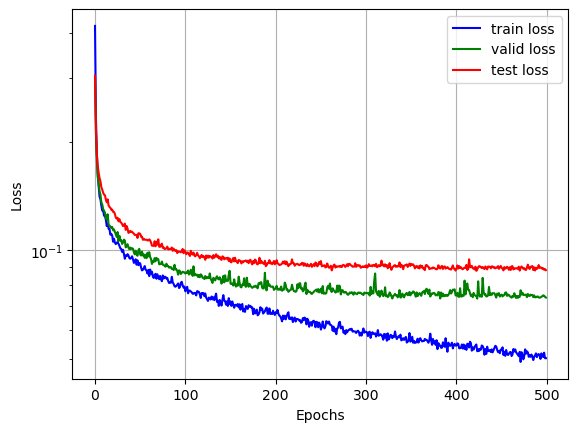

In [28]:
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(valid_loss, color='green', label='valid loss')
plt.plot(test_loss, color='red', label='test loss')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

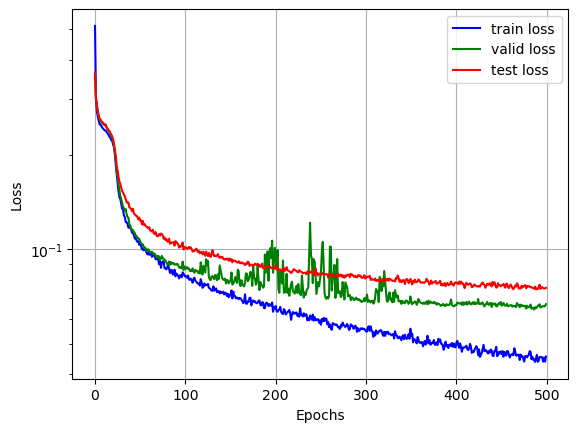

In [41]:
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(valid_loss, color='green', label='valid loss')
plt.plot(test_loss, color='red', label='test loss')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

In [32]:
batch_size = BATCH_SIZE
n_epochs = 200

train_loader = dl_train_unseen
valid_loader = dl_valid_unseen
test_loader = dl_test_unseen

#i = 0
for i in range(1):
    print('TRAINING MODEL %d' %i)
    # Instantiate the model
    model =PTPNet(1,3,32).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1.E-4)
    criterion = nn.BCEWithLogitsLoss()
    fn = 'UKDALE_unseen_8_1110%d.pth' %i
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, fn)

TRAINING MODEL 0
[  1/200] train_loss: 0.55720 valid_loss: 0.41295 test_loss: 0.37032 
验证损失减少 (inf --> 0.412950). 正在保存模型...
[  2/200] train_loss: 0.32048 valid_loss: 0.31326 test_loss: 0.26562 
验证损失减少 (0.412950 --> 0.313255). 正在保存模型...
[  3/200] train_loss: 0.29012 valid_loss: 0.29401 test_loss: 0.25199 
验证损失减少 (0.313255 --> 0.294015). 正在保存模型...
[  4/200] train_loss: 0.27359 valid_loss: 0.27707 test_loss: 0.24691 
验证损失减少 (0.294015 --> 0.277070). 正在保存模型...
[  5/200] train_loss: 0.25713 valid_loss: 0.26521 test_loss: 0.23920 
验证损失减少 (0.277070 --> 0.265210). 正在保存模型...
[  6/200] train_loss: 0.25281 valid_loss: 0.26050 test_loss: 0.23716 
验证损失减少 (0.265210 --> 0.260498). 正在保存模型...
[  7/200] train_loss: 0.24944 valid_loss: 0.25866 test_loss: 0.23595 
验证损失减少 (0.260498 --> 0.258662). 正在保存模型...
[  8/200] train_loss: 0.24987 valid_loss: 0.25570 test_loss: 0.23446 
验证损失减少 (0.258662 --> 0.255697). 正在保存模型...
[  9/200] train_loss: 0.24751 valid_loss: 0.25428 test_loss: 0.23455 
验证损失减少 (0.255697 --> 0

[ 92/200] train_loss: 0.08556 valid_loss: 0.09269 test_loss: 0.09506 
[ 93/200] train_loss: 0.08337 valid_loss: 0.09147 test_loss: 0.10274 
验证损失减少 (0.091939 --> 0.091465). 正在保存模型...
[ 94/200] train_loss: 0.08279 valid_loss: 0.09193 test_loss: 0.09939 
[ 95/200] train_loss: 0.08319 valid_loss: 0.09137 test_loss: 0.09755 
验证损失减少 (0.091465 --> 0.091365). 正在保存模型...
[ 96/200] train_loss: 0.08437 valid_loss: 0.09042 test_loss: 0.09903 
验证损失减少 (0.091365 --> 0.090424). 正在保存模型...
[ 97/200] train_loss: 0.08420 valid_loss: 0.08964 test_loss: 0.09437 
验证损失减少 (0.090424 --> 0.089637). 正在保存模型...
[ 98/200] train_loss: 0.08453 valid_loss: 0.09320 test_loss: 0.10003 
[ 99/200] train_loss: 0.08205 valid_loss: 0.08888 test_loss: 0.10465 
验证损失减少 (0.089637 --> 0.088884). 正在保存模型...
[100/200] train_loss: 0.08401 valid_loss: 0.09271 test_loss: 0.10525 
[101/200] train_loss: 0.08406 valid_loss: 0.09182 test_loss: 0.09717 
[102/200] train_loss: 0.08372 valid_loss: 0.09027 test_loss: 0.09536 
[103/200] train_loss

[197/200] train_loss: 0.06925 valid_loss: 0.08193 test_loss: 0.09181 
[198/200] train_loss: 0.06944 valid_loss: 0.08267 test_loss: 0.11145 
[199/200] train_loss: 0.06906 valid_loss: 0.08096 test_loss: 0.10751 
[200/200] train_loss: 0.06826 valid_loss: 0.08118 test_loss: 0.09283 


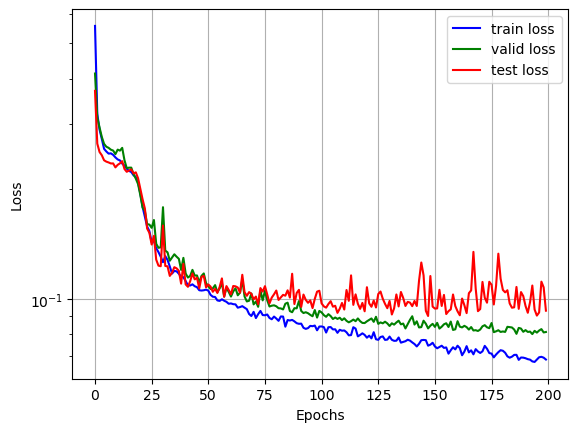

In [33]:
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(valid_loss, color='green', label='valid loss')
plt.plot(test_loss, color='red', label='test loss')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

In [32]:
model = PTPNet(1,3,32).cuda()
model.eval()

PTPNet(
  (encoder1): Encoder(
    (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool1_1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (encoder2): Encoder(
    (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2_1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (encoder3): Encoder(
    (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)


这段代码定义了一个名为model的神经网络模型。该模型是一个PTPNet模型，输入维度为1，输出维度为3，隐藏层维度为32。通过调用.cuda()方法，将模型移动到GPU上进行计算。接下来，代码调用model.eval()将模型设置为评估模式，表示在进行推理时不进行梯度计算和参数更新。

总结：这段代码定义了一个PTPNet模型，并将其移动到GPU上进行评估模式的设置。

In [26]:
scores = {}
for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.5
for i in range(1):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_seen_%d.pth' %i
    filename = './UKDALE_seen_12_1110%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[0], a)
        #pm = p_true.sum() / s_true.sum()
        #pm = (ds_appliance[0][APPLIANCE[a]] * 
        #      ds_status[0][APPLIANCE[a]]).sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        #计算了一个家电设备的平均功率（pm），并将其除以最大功率（MAX_POWER）进行归一化处理。
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())
        

for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[0], sorted(scores[i]['F1'])[0]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[0], sorted(scores[i]['Precision'])[0]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[0], sorted(scores[i]['Recall'])[0]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[0], sorted(scores[i]['Accuracy'])[0]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[0], sorted(scores[i]['MCC'])[0]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[0], sorted(scores[i]['MAE'])[0]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[0], sorted(scores[i]['SAE'])[0]))

./UKDALE_seen_12_11100.pth

fridge
F1 score  : 0.881 (0.881, 0.881)
Precision : 0.891 (0.891, 0.891)
Recall    : 0.872 (0.872, 0.872)
Accuracy  : 0.893 (0.893, 0.893)
MCC       : 0.784 (0.784, 0.784)
MAE       : 14.10 (14.10, 14.10)
SAE       : -0.024 (-0.024, -0.024)

dish_washer
F1 score  : 0.875 (0.875, 0.875)
Precision : 0.834 (0.834, 0.834)
Recall    : 0.920 (0.920, 0.920)
Accuracy  : 0.994 (0.994, 0.994)
MCC       : 0.873 (0.873, 0.873)
MAE       : 22.35 (22.35, 22.35)
SAE       : 0.082 (0.082, 0.082)

washing_machine
F1 score  : 0.981 (0.981, 0.981)
Precision : 0.983 (0.983, 0.983)
Recall    : 0.979 (0.979, 0.979)
Accuracy  : 0.997 (0.997, 0.997)
MCC       : 0.979 (0.979, 0.979)
MAE       : 41.69 (41.69, 41.69)
SAE       : -0.087 (-0.087, -0.087)


In [33]:
scores = {}
for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.5
for i in range(20):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_seen_%d.pth' %i
    filename = './UKDALE_seen_11_1110%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[0], a)
        #pm = p_true.sum() / s_true.sum()
        #pm = (ds_appliance[0][APPLIANCE[a]] * 
        #      ds_status[0][APPLIANCE[a]]).sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        #计算了一个家电设备的平均功率（pm），并将其除以最大功率（MAX_POWER）进行归一化处理。
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())
        

for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[1], sorted(scores[i]['F1'])[18]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[1], sorted(scores[i]['Precision'])[18]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[1], sorted(scores[i]['Recall'])[18]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[1], sorted(scores[i]['Accuracy'])[18]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[1], sorted(scores[i]['MCC'])[18]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[1], sorted(scores[i]['MAE'])[18]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[1], sorted(scores[i]['SAE'])[18]))

./UKDALE_seen_11_11100.pth
./UKDALE_seen_11_11101.pth
./UKDALE_seen_11_11102.pth
./UKDALE_seen_11_11103.pth
./UKDALE_seen_11_11104.pth
./UKDALE_seen_11_11105.pth
./UKDALE_seen_11_11106.pth
./UKDALE_seen_11_11107.pth
./UKDALE_seen_11_11108.pth
./UKDALE_seen_11_11109.pth
./UKDALE_seen_11_111010.pth
./UKDALE_seen_11_111011.pth
./UKDALE_seen_11_111012.pth
./UKDALE_seen_11_111013.pth
./UKDALE_seen_11_111014.pth
./UKDALE_seen_11_111015.pth
./UKDALE_seen_11_111016.pth
./UKDALE_seen_11_111017.pth
./UKDALE_seen_11_111018.pth
./UKDALE_seen_11_111019.pth

fridge
F1 score  : 0.899 (0.895, 0.902)
Precision : 0.902 (0.896, 0.907)
Recall    : 0.895 (0.890, 0.902)
Accuracy  : 0.908 (0.905, 0.911)
MCC       : 0.815 (0.809, 0.821)
MAE       : 12.77 (12.52, 13.03)
SAE       : -0.009 (-0.021, 0.006)

dish_washer
F1 score  : 0.943 (0.921, 0.966)
Precision : 0.938 (0.896, 0.965)
Recall    : 0.948 (0.923, 0.967)
Accuracy  : 0.997 (0.996, 0.998)
MCC       : 0.941 (0.919, 0.965)
MAE       : 20.58 (20.14, 21.33

 这段代码主要是为了评估一个模型在多个房屋的表现。首先，它创建了一个名为scores的字典，其中包含了每个房屋的评价指标，如F1得分、精度、召回率、准确率、MCC、MAE和SAE。然后，它对20个不同的模型进行了评估，每个模型分别对应一个.pth文件。对于每个模型和每个房屋，它计算了相应的预测结果，并将这些结果与真实结果进行比较，从而计算出每个房屋的评价指标。最后，它输出了每个房屋的平均评价指标，并显示了每个指标的最小值和最大值。

In [ ]:
import matplotlib.pyplot as plt

# 初始化数据
a_values = [0, 1, 2]
f1_scores = [[] for _ in range(3)]  # 用于存储三种a值对应的F1分值

# 从scores字典中提取F1分值
for a in range(3):
    f1_scores[a] = scores[a]['F1']

# 家电设备名称
appliance_labels = ['Fridge', 'Dish Washer', 'Washing Machine']

# 绘制折线图
plt.figure(figsize=(8, 6))
for a in range(3):
    plt.plot(range(20), f1_scores[a], label=appliance_labels[a])  # 每种a值对应的F1分值折线
plt.xticks(range(0, 21, 2))  # 设置横坐标刻度为2一格
plt.xlabel("Iteration")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Iteration for Different Appliances")
plt.legend()
# 设置分辨率为600ppi
dpi = 600

# 选择文件路径和文件名，保存为PNG格式
save_path = r'D:\NILM\绘图\F1折线图.png'

# 导出图片
#plt.savefig(save_path, dpi=dpi)
plt.show()


./UKDALE_seen_9_11100_300.pth


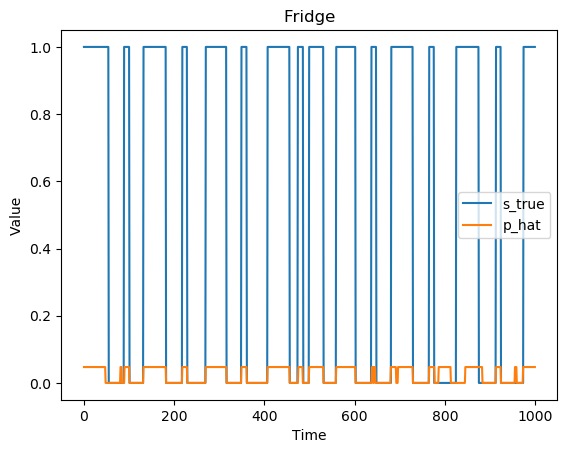

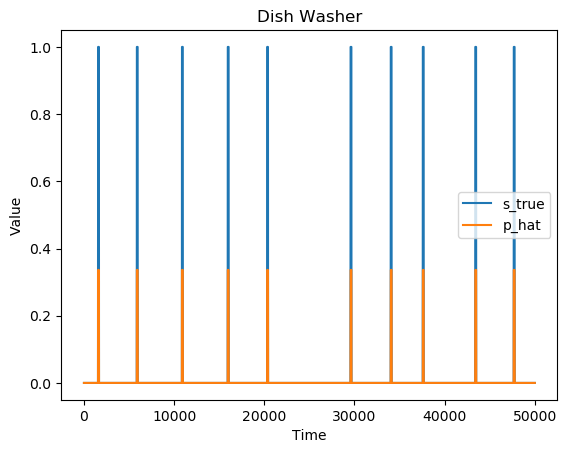

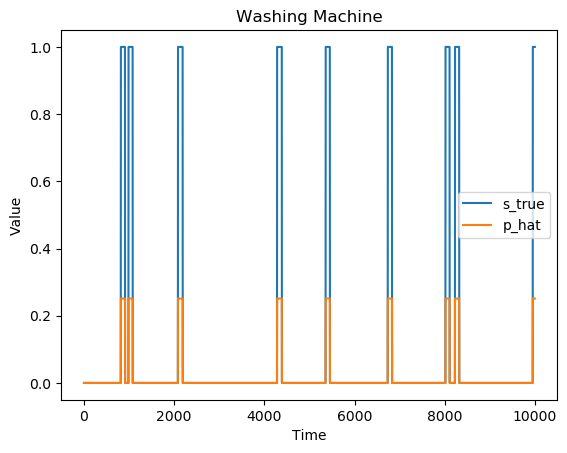

In [30]:

thr = 0.5
for i in range(1):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_seen_%d.pth' %i
    filename = './UKDALE_seen_11_1110%d.pth' %(i+15)
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):#1为fridge，2为dish_washer，3为washing_machine
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[0], a)
        #pm = p_true.sum() / s_true.sum()
        #pm = (ds_appliance[0][APPLIANCE[a]] * 
        #      ds_status[0][APPLIANCE[a]]).sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        #计算了一个家电设备的平均功率（pm），并将其除以最大功率（MAX_POWER）进行归一化处理。
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = 0.8*s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())
        # 绘制折线图
        #plt.plot(s_true[:1000], label='s_true')
        #plt.plot(p_true[:5000], label='p_true')
        #plt.plot(p_hat[:1000], label='p_hat')

        if a == 0:
            device_name = "Fridge"
            plt.plot(s_true[:10000], label='s_true')
            plt.plot(p_hat[:10000], label='p_hat')
            # 添加标题、x轴标签和y轴标签
            plt.title(device_name)
            plt.xlabel("Time")
            plt.ylabel("Value")
            # 添加图例
            plt.legend()
            # 设置分辨率为600ppi
            dpi = 600

            # 选择文件路径和文件名，保存为PNG格式
            save_path = r'D:\NILM\绘图\冰箱图(10000).png'

            # 导出图片
            #plt.savefig(save_path, dpi=dpi)
            #plt.savefig('D:/NILM/小论文/基于并行多尺度注意力的非侵入式负荷分解/论文图/冰箱图.pdf')
        elif a == 1:
            device_name = "Dish Washer"
            plt.plot(s_true[:10000]*mean[a], label='s_true')
            plt.plot(p_hat[:10000]*mean[a], label='p_hat')
            # 添加标题、x轴标签和y轴标签
            plt.title(device_name)
            plt.xlabel("Time")
            plt.ylabel("Value")
            # 添加图例
            plt.legend()
            #plt.savefig('D:/NILM/小论文/基于并行多尺度注意力的非侵入式负荷分解/论文图/洗碗机图.pdf')
            # 设置分辨率为600ppi
            dpi = 600

            # 选择文件路径和文件名，保存为PNG格式
            save_path = r'D:\NILM\绘图\洗碗机图(10000).png'

            # 导出图片
            #plt.savefig(save_path, dpi=dpi)
        elif a == 2:
            device_name = "Washing Machine"
            s_true[0:100] = 0
            plt.plot(s_true[:10000], label='s_true')
            plt.plot(p_hat[:10000], label='p_hat')
            plt.title(device_name)
            plt.xlabel("Time")
            plt.ylabel("Value")
            # 添加图例
            plt.legend()
            #plt.savefig('D:/NILM/小论文/基于并行多尺度注意力的非侵入式负荷分解/论文图/洗衣机图.pdf')
            # 设置分辨率为600ppi
            dpi = 600

            # 选择文件路径和文件名，保存为PNG格式
            save_path = r'D:\NILM\绘图\洗衣机图(10000).png'

            # 导出图片
            #plt.savefig(save_path, dpi=dpi)
        else:
            device_name = "Appliance " + str(a)


        # 添加标题、x轴标签和y轴标签
        plt.title(device_name)
        plt.xlabel("Time")
        plt.ylabel("Value")

        # 添加图例
        plt.legend()

        # 显示图形
        plt.show()


In [36]:
scores = {}

for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []
    scores[a]['s_true'] = []
    scores[a]['s_hat'] = []

thr = 0.5

for i in range(1):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_unseen_%d.pth' %i
    filename = './UKDALE_unseen_8_1110%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        #pm = p_true.sum() / s_true.sum()
        pm = ds_appliance[1][APPLIANCE[a]].sum() / ds_status[1][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['s_true'].append(s_true)
        scores[a]['s_hat'].append(s_hat)
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())

for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[0], sorted(scores[i]['F1'])[0]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[0], sorted(scores[i]['Precision'])[0]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[0], sorted(scores[i]['Recall'])[0]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[0], sorted(scores[i]['Accuracy'])[0]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[0], sorted(scores[i]['MCC'])[0]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[0], sorted(scores[i]['MAE'])[0]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[0], sorted(scores[i]['SAE'])[0]))

./UKDALE_unseen_8_11100.pth

fridge
F1 score  : 0.847 (0.847, 0.847)
Precision : 0.818 (0.818, 0.818)
Recall    : 0.877 (0.877, 0.877)
Accuracy  : 0.880 (0.880, 0.880)
MCC       : 0.750 (0.750, 0.750)
MAE       : 19.90 (19.90, 19.90)
SAE       : 0.072 (0.072, 0.072)

dish_washer
F1 score  : 0.776 (0.776, 0.776)
Precision : 0.704 (0.704, 0.704)
Recall    : 0.864 (0.864, 0.864)
Accuracy  : 0.986 (0.986, 0.986)
MCC       : 0.773 (0.773, 0.773)
MAE       : 38.38 (38.38, 38.38)
SAE       : 0.226 (0.226, 0.226)

washing_machine
F1 score  : 0.838 (0.838, 0.838)
Precision : 0.846 (0.846, 0.846)
Recall    : 0.830 (0.830, 0.830)
Accuracy  : 0.996 (0.996, 0.996)
MCC       : 0.836 (0.836, 0.836)
MAE       : 8.33 (8.33, 8.33)
SAE       : -0.020 (-0.020, -0.020)
